In [9]:
# Header for the notebook
from datetime import datetime
from IPython.display import display, Markdown

# Get the current date
title = "Coding Project Notebook - Circular Task"
current_date = datetime.now().strftime("%d %B %Y, %H:%M:%S")
authors = "Victor Salvat and Jin Wei Zhang (and Copilot)"

# Insert the date into the notebook
display(Markdown(f"# {title}"))
display(Markdown(f"{current_date}"))
display(Markdown(f"by {authors}"))

# Coding Project Notebook - Circular Task

29 November 2025, 00:41:46

by Victor Salvat and Jin Wei Zhang (and Copilot)

Introduction



## Table of Contents
<a id="total-title"></a>
- [1. Recreate figures and plots (visual reproduction)](#1-title)
- [2. Reproduce marker measurements (data verification)](#2-title)
- [3. Generate and analyze circular task data](#3-title)
- [4. Discussion, limitations, and conclusions](#4-title)

---
<a id="1-title"></a>
# 1. Recreate figures and plots (visual reproduction)

In [10]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import matplotlib.patches as patches
from matplotlib import patches
from matplotlib.lines import Line2D


# install widget mode
%matplotlib widget

Found indices of original X≈0 split points: [ 3972  7871 11770 15655 19592]
Number of split points: 5 (should be 5)

Group 1 data: Indices [0, 3971], Data length: 3972

Group 2 data: Indices [3973, 7870], Data length: 3898

Group 3 data: Indices [7872, 11769], Data length: 3898

Group 4 data: Indices [11771, 15654], Data length: 3884

Group 5 data: Indices [15656, 19591], Data length: 3936

Successfully split into 5 valid data groups


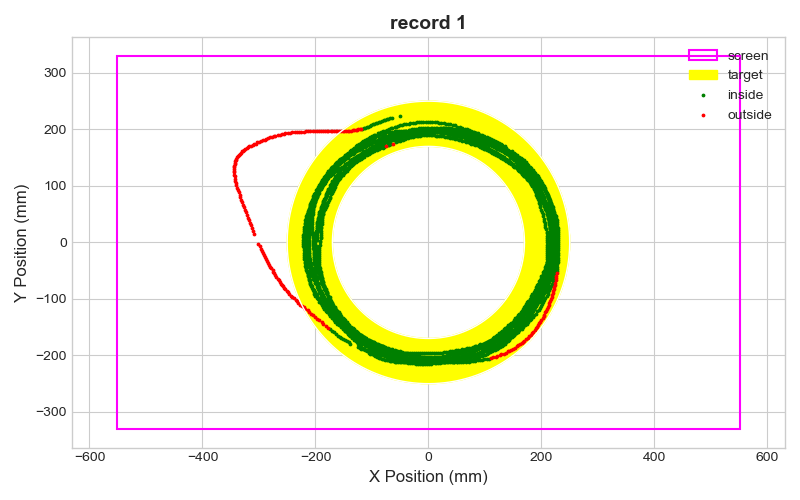

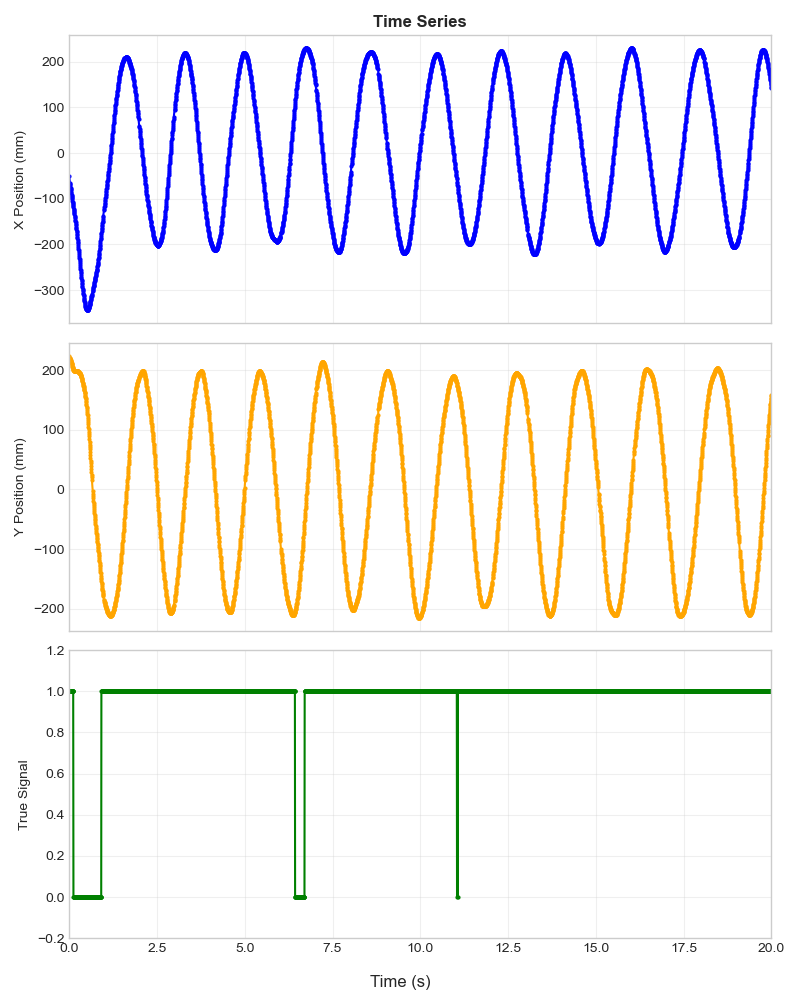

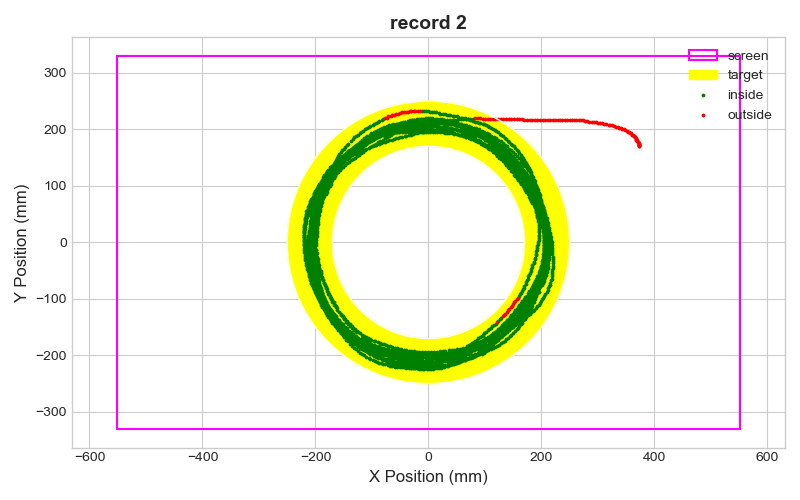

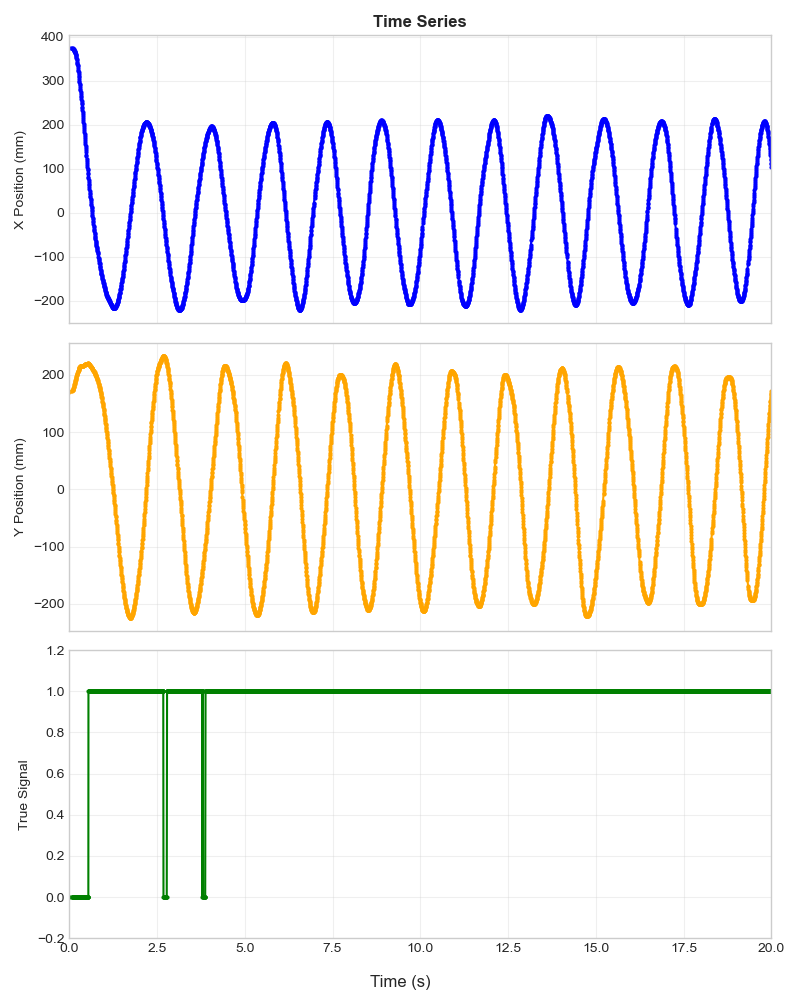

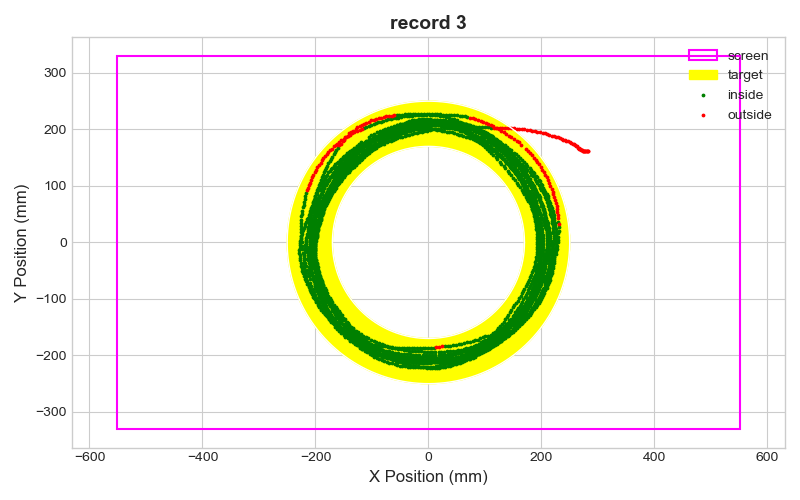

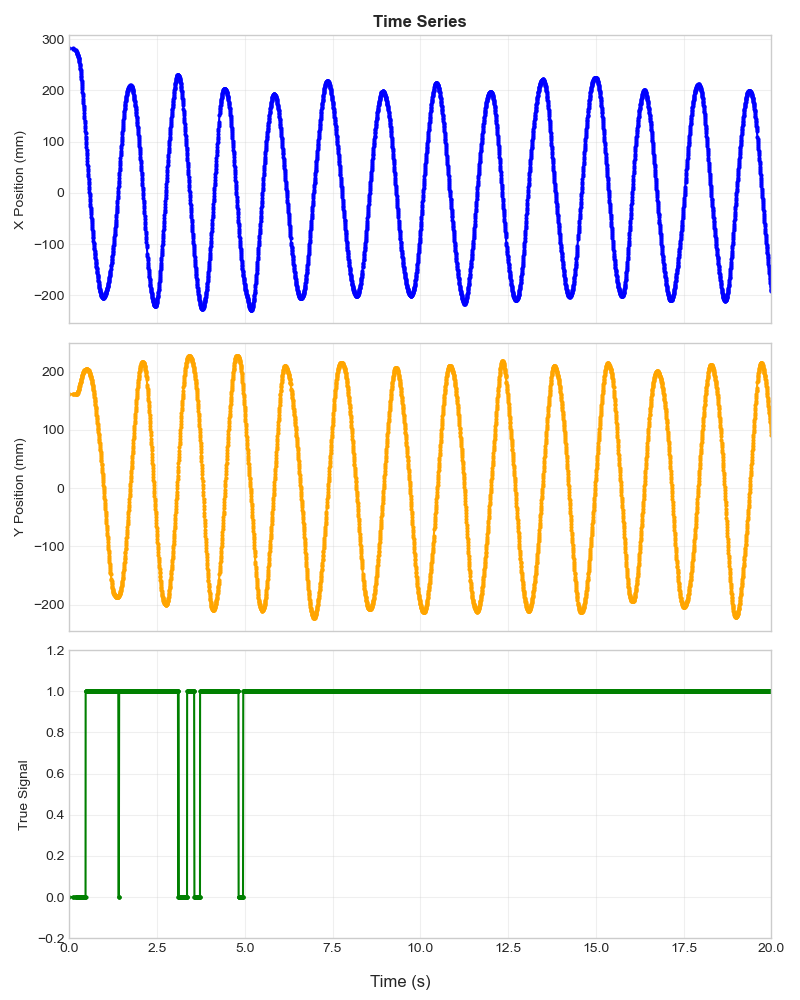

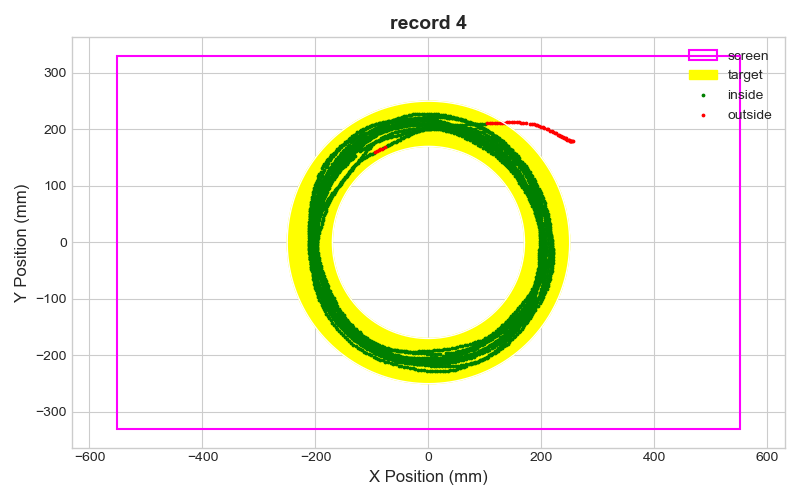

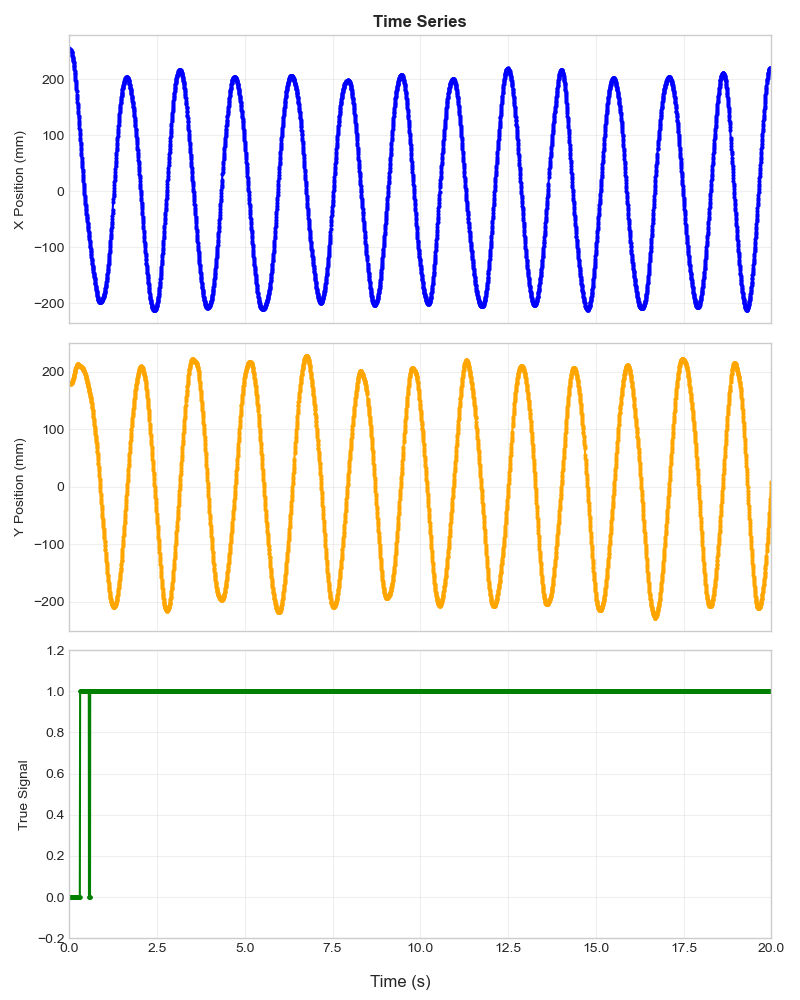

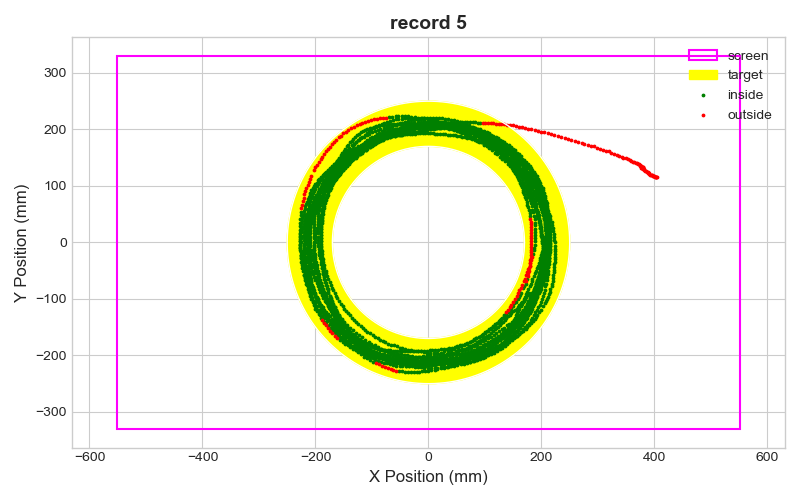

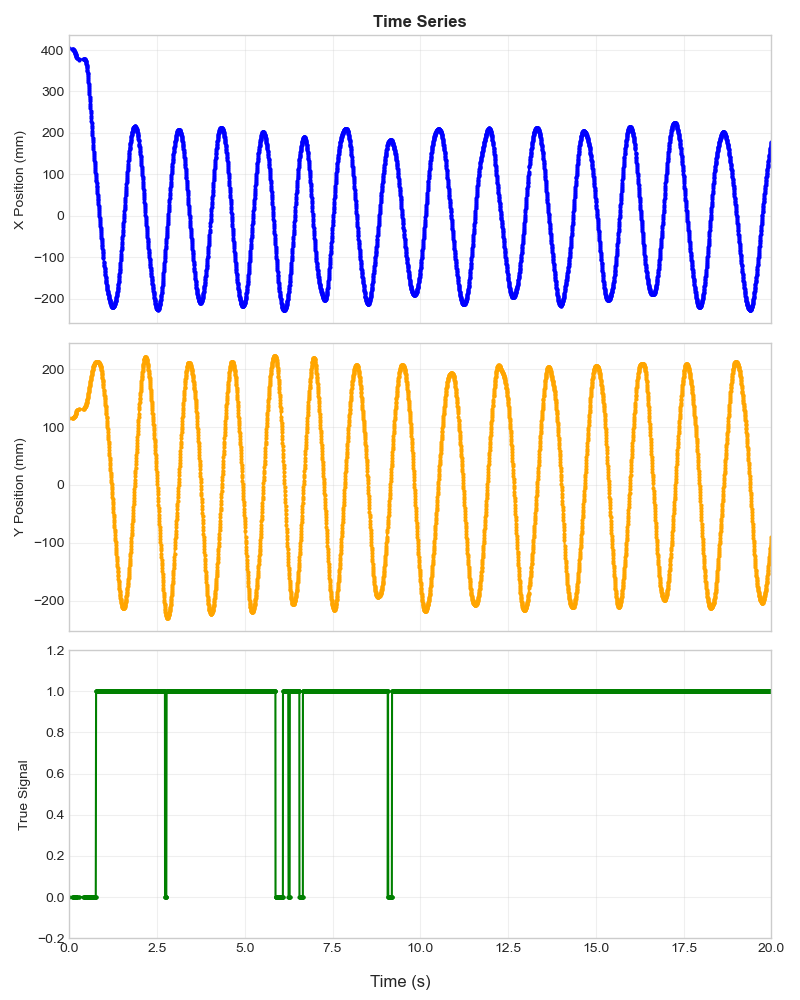

In [11]:
file_name = 'data\\001MoDe_R1.csv'
data = np.genfromtxt(file_name, delimiter=',', skip_header=4)

time_1 = data[:, 0]
x_position = data[:, 1] - 552  # X-axis: [-552,552] (origin aligned with target center)
y_position = data[:, 2] - 330  # Y-axis: [-330,330] (origin aligned with target center)
# True_signal is not used; position is determined by distance

# ----------------------
# Core: 5 original X=0 points → strictly split into 5 data groups (independent time per group)
# ----------------------
raw_x = data[:, 1]  # Original X-coordinate (without subtracting 552)
zero_x_indices = np.where(np.abs(raw_x) < 0.5)[0]
print(f"Found indices of original X≈0 split points: {zero_x_indices}")
print(f"Number of split points: {len(zero_x_indices)} (should be 5)")

if len(zero_x_indices) != 5:
    raise ValueError(f"Expected 5 original X=0 split points, but found {len(zero_x_indices)}. Please check the data!")

# Loop to split into 5 data groups (strictly according to requirements)
data_groups = []
for i in range(5):
    if i == 0:
        # Group 1: Index 1 → before first split point (excludes split point)
        start_idx = 0
        end_idx = zero_x_indices[0] - 1
    else:
        # Groups 2-5: After previous split point → before current split point (excludes both split points)
        start_idx = zero_x_indices[i-1] + 1
        end_idx = zero_x_indices[i] - 1
    
    # Ensure valid indices (start_idx < end_idx)
    if start_idx >= end_idx:
        print(f"Warning: Invalid indices for Group {i+1} ([{start_idx}, {end_idx}]), skipping this group!")
        continue
    
    # Extract all data for current group (X/Y/time/True Signal, only valid for current group)
    group = {
        'group_num': i+1,
        'start_idx': start_idx,
        'end_idx': end_idx,
        'x': x_position[start_idx:end_idx+1],  # Slice is right-exclusive, need +1
        'y': y_position[start_idx:end_idx+1],
        'time': time_1[start_idx:end_idx+1],   # Independent time per group, only current group range
        'true_signal': data[:, 3][start_idx:end_idx+1]
    }
    data_groups.append(group)
    print(f"\nGroup {i+1} data: Indices [{start_idx}, {end_idx}], Data length: {len(group['x'])}")

print(f"\nSuccessfully split into {len(data_groups)} valid data groups")

# ----------------------
# Loop to plot each group (2 plots per group: separate trajectory plot + 3 independent time subplots)
# ----------------------
externalRadius = 250.0
internalRadius = 170.0
screen_x = [-552, 552, 552, -552, -552]
screen_y = [-330, -330, 330, 330, -330]
theta = np.linspace(0, 2*np.pi, 1000)
outer_circle_x = externalRadius * np.cos(theta)
outer_circle_y = externalRadius * np.sin(theta)
inner_circle_x = internalRadius * np.cos(theta)
inner_circle_y = internalRadius * np.sin(theta)

for group in data_groups:
    group_num = group['group_num']
    x = group['x']
    y = group['y']
    time = group['time']  # Time only for current group, changes with each loop
    true_signal = group['true_signal']
    
    # ----------------------
    # Plot 1: Separate trajectory plot for the group (original logic unchanged)
    # ----------------------
    plt.figure(figsize=(8, 5))
    
    # 1. Bottom layer: Screen
    screen = patches.Polygon(list(zip(screen_x, screen_y)), closed=True, linewidth=1.5, edgecolor="magenta", facecolor="none", label="screen")
    plt.gca().add_patch(screen)
    
    
    # 2. Middle layer: Yellow annular background
    ring = Wedge(
        center=(0, 0),
        r=externalRadius,
        theta1=0, theta2=360,
        width=externalRadius - internalRadius,
        color="#FFFF00",
        alpha=1.0,
        label='target'
    )
    plt.gca().add_patch(ring)
    
    # 3. Top layer: Target borders
    plt.plot(outer_circle_x, outer_circle_y, color='white', linewidth=1.0)
    plt.plot(inner_circle_x, inner_circle_y, color='white', linewidth=1.0)
    
    # 4. Color-coded trajectory (ring-swapped logic)
    # distances = np.sqrt(x**2 + y**2)
    # x_red = x[(distances >= internalRadius) & (distances <= externalRadius)]  # Outside → red
    # y_red = y[(distances >= internalRadius) & (distances <= externalRadius)]
    # x_green = x[(distances < internalRadius) | (distances > externalRadius)]  # Inside → green
    # y_green = y[(distances < internalRadius) | (distances > externalRadius)]
    
    threshold = 0.5  # Since true_signal is binary (0 or 1)
    x_green = x[true_signal >= threshold]  # true_signal=1 → green (original "outside" label)
    y_green = y[true_signal >= threshold]
    x_red = x[true_signal < threshold]    # true_signal=0 → red (original "inside" label)
    y_red = y[true_signal < threshold]

    plt.scatter(x_green, y_green, s=3, color='green', label='inside')
    plt.scatter(x_red, y_red, s=3, color='red', label='outside')
    
    # Style adjustments
    plt.title(f'record {group_num}', fontweight='bold', fontsize=14)
    plt.xlabel('X Position (mm)', fontsize=12)
    plt.ylabel('Y Position (mm)', fontsize=12)
    plt.xlim([-552, 552])
    plt.ylim([-330, 330])
    #plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right', fontsize=10)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    # ----------------------
    # Plot 2: 3 time series subplots for the group (time only for current group, normalized to 0~20s)
    # ----------------------
    
    # ----------------------
    # Plot 2: 3 time series subplots for the group (time only for current group, normalized to 0~20s)
    # ----------------------
    fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

    # Normalize time to 0~20 seconds (only using current group's time, recalculated each loop)
    time_min, time_max = time.min(), time.max()
    if time_max - time_min < 1e-6:
        time_mapped = np.zeros_like(time)
    else:
        time_mapped = (time - time_min) / (time_max - time_min) * 20
        
    # Subplot 1: Time vs X Position (current group time)
    axs[0].plot(time_mapped, x, marker='o', markersize=2, color='blue')
    axs[0].set_ylabel("X Position (mm)")
    axs[0].set_title(f"Time Series", fontweight="bold")
    axs[0].grid(alpha=0.3)
    axs[0].set_xlim([0, 20])
    
    # Subplot 2: Time vs Y Position (current group time)
    axs[1].plot(time_mapped, y, marker='o', markersize=2, color='orange')
    axs[1].set_ylabel("Y Position (mm)")
    axs[1].grid(alpha=0.3)

    # Subplot 3: Time vs Original True Signal (current group time)
    axs[2].plot(time_mapped, true_signal, marker='o', markersize=2, color='green')
    axs[2].set_ylabel("True Signal")
    axs[2].grid(alpha=0.3)
    axs[2].set_ylim([-0.2, 1.2])
    # Single global X label
    fig.supxlabel("Time (s)")

    plt.tight_layout()
    plt.show()

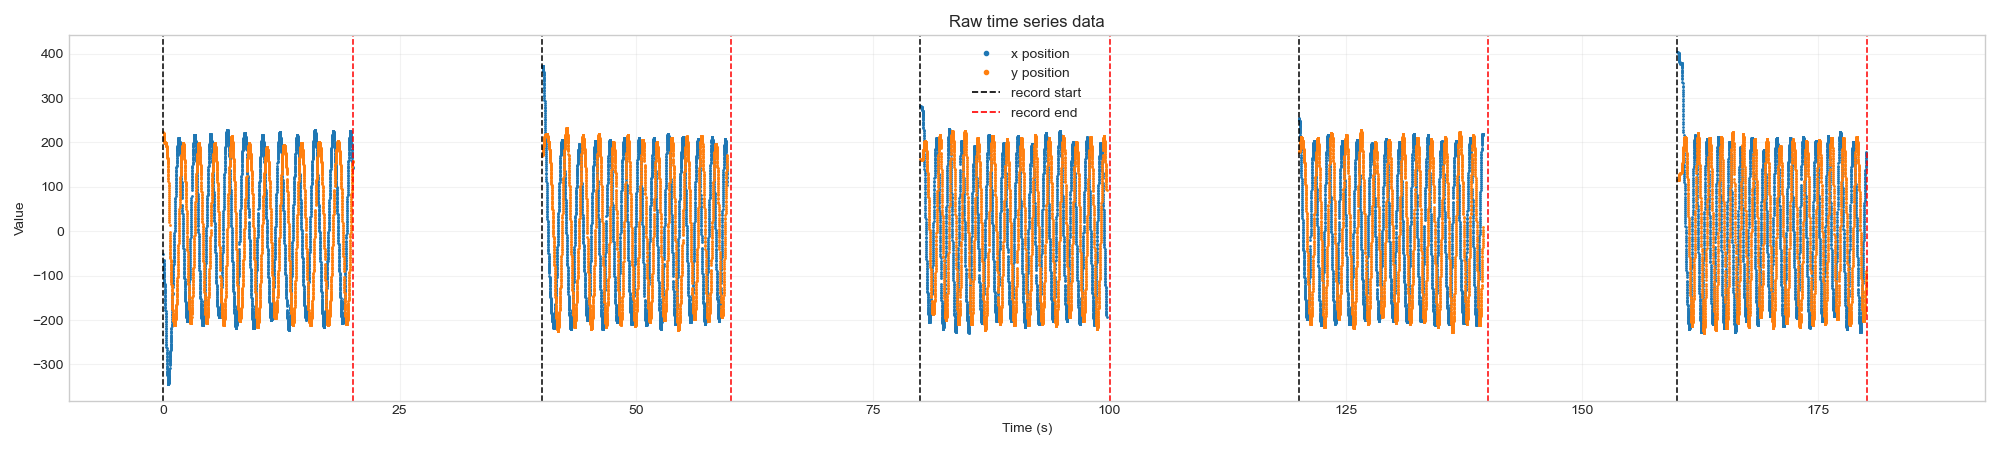

In [12]:
# -----------------------------------------------------
# Combined raw time-series plot for all 5 data groups
# -----------------------------------------------------
rec_start = np.array([0.004, 40.011, 80.043, 120.061, 160.090])    # record times
rec_end   = np.array([20.007, 60.022, 100.057, 140.075, 180.104])  # record times

plt.figure(figsize=(20, 4.5))

# Plot each group at the correct global time (seconds)
for i, group in enumerate(data_groups):
    t = group['time']
    x = group['x']
    y = group['y']

    # Convert group-local time to seconds starting at 0.0 s
    t_seconds = (t - t.min()) / 1000.0

    # Shift to the known record start time (seconds)
    t_global = t_seconds + rec_start[i]

    # Plot with fixed colors
    plt.plot(t_global, x, '.', ms=2, color='tab:blue', label='x position' if i == 0 else None)
    plt.plot(t_global, y, '.', ms=2, color='tab:orange', label='y position' if i == 0 else None)

# Plot vertical lines for start and end of each record
for j in range(len(rec_start)):
    plt.axvline(rec_start[j], color='black', linestyle='--', linewidth=1.1,
                label='record start' if j == 0 else None)
    plt.axvline(rec_end[j],   color='red',   linestyle='--', linewidth=1.1,
                label='record end' if j == 0 else None)
    
# Create custom legend elements
legend_elements = [
    Line2D([], [], color='tab:blue',   marker='.', linestyle='None', markersize=6, label='x position'),
    Line2D([], [], color='tab:orange', marker='.', linestyle='None', markersize=6, label='y position'),
    Line2D([], [], color='black', linestyle='--', linewidth=1.2, label='record start'),
    Line2D([], [], color='red',   linestyle='--', linewidth=1.2, label='record end')
]

# Final plot adjustments
plt.xlim(rec_start[0] - 10.0, rec_end[-1] + 12.5)
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.title("Raw time series data")
plt.grid(alpha=0.25)
plt.legend(handles=legend_elements, loc='upper center', ncol=1, frameon=False)
plt.tight_layout()
plt.show()

<a id="2-title"></a>
# 2. [Reproduce marker measurements (data verification)](#total-title)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# Load data
# ----------------------
file_name = 'data\\001MoDe_R1.csv'
data = np.genfromtxt(file_name, delimiter=',', skip_header=4)

time_ms = data[:, 0]
x_position = data[:, 1] - 552  # centered
y_position = data[:, 2] - 330  # centered
true_signal_all = data[:, 3]
raw_x = data[:, 1]

# ----------------------
# Split into record groups using X ≈ 0 markers
# ----------------------
zero_x_indices = np.where(np.abs(raw_x) < 0.5)[0]
data_groups = []

for i in range(5):
    if i == 0:
        start_idx = 0
        end_idx = zero_x_indices[0] - 1 if len(zero_x_indices) > 0 else len(raw_x) - 1
    else:
        start_idx = zero_x_indices[i-1] + 1
        end_idx = zero_x_indices[i] - 1 if i < len(zero_x_indices) else len(raw_x) - 1
    
    if start_idx >= end_idx or start_idx >= len(raw_x):
        continue
    
    group = {
        'group_num': i+1,
        'start_idx': start_idx,
        'end_idx': end_idx,
        'x': x_position[start_idx:end_idx+1],
        'y': y_position[start_idx:end_idx+1],
        'time': time_ms[start_idx:end_idx+1],
        'true_signal': true_signal_all[start_idx:end_idx+1]
    }
    data_groups.append(group)

# ----------------------
# Constants from configuration
# ----------------------
R_theory = 209.5   # px (theoretical radius)
T_theory = 47.0    # px (theoretical tolerance)

# Task limits (adjust these based on your configuration)
EXTERNAL_LIMIT = 250  # outer radius in pixels
INTERNAL_LIMIT = 170  # inner radius in pixels

def compute_metrics(g):
    """
    Compute performance metrics matching the Java implementation.
    """
    x, y = g['x'], g['y']
    t_ms = g['time']  # Keep in milliseconds initially
    sig = g['true_signal']
    
    # Compute radius from center
    r = np.sqrt(x**2 + y**2)
    
    # Compute angles (Note: negate y to match Java coordinate system)
    # Java uses screen coordinates where Y increases downward
    angles = np.arctan2(-y, x)  # Negative y for screen coordinates
    
    # ---- Find first entry into target (annulus) ----
    inside_mask = (r >= INTERNAL_LIMIT) & (r <= EXTERNAL_LIMIT)
    inside_idx = np.where(inside_mask)[0]
    
    if len(inside_idx) == 0:
        return None
    
    i0 = inside_idx[0]  # First time inside target
    first_time_in = t_ms[i0]
    
    # Trim arrays to valid interval (from first entry onward)
    r = r[i0:]
    angles = angles[i0:]
    t_ms = t_ms[i0:]
    sig = sig[i0:]
    x = x[i0:]
    y = y[i0:]
    
    # ---- Compute angular distance (matching Java phaseAngle logic) ----
    # Calculate angular differences, handling wraparound
    angle_diffs = np.diff(angles)
    
    # Unwrap angles: correct jumps around ±π (matching Java logic exactly)
    angle_diffs = np.where(angle_diffs > np.pi, angle_diffs - 2*np.pi, angle_diffs)
    angle_diffs = np.where(angle_diffs < -np.pi, angle_diffs + 2*np.pi, angle_diffs)
    
    # Total angular distance (sum of all incremental angles with sign)
    total_angle = np.sum(angle_diffs)
    
    # ---- nLaps ----
    # Java: angleTotalTable[i] / (2*Math.PI)
    # Note: Sign indicates direction (negative = counter-clockwise)
    nLaps = total_angle / (2 * np.pi)
    
    if abs(nLaps) < 0.01:  # Avoid division by zero
        return None
    
    # ---- Movement Time ----
    # Java: MTe = (time - fistTimeIn) / 1000 (converts ms to seconds)
    total_time_ms = t_ms[-1] - t_ms[0]
    total_time_s = total_time_ms / 1000.0
    MT_per_lap = total_time_s / abs(nLaps)
    
    # ---- Re (effective radius) ----
    # Java: radiusMean (simple mean of all radii)
    Re = np.mean(r)
    
    # ---- Te (effective tolerance) ----
    # Java: effectiveTolerance = Math.sqrt(2 * Math.PI * Math.E) * radiusStd
    # This is approximately 4.133 * std
    radiusStd = np.std(r, ddof=1)  # Sample std (n-1)
    Te = np.sqrt(2 * np.pi * np.e) * radiusStd
    
    # ---- Error percentage ----
    # Java: 100 * errAngle / totAngle
    # Uses the true_signal column to determine if inside/outside target
    # true_signal appears to be 1.0 when inside, 0.0 when outside
    inside_target = sig >= 0.5  # Threshold at 0.5
    outside_mask = ~inside_target[:-1]  # Exclude last point for diff alignment
    
    # Sum absolute angular distances when outside target
    angle_outside = np.sum(np.abs(angle_diffs[outside_mask]))
    
    # Calculate error as percentage of total angular distance
    error = 100.0 * angle_outside / abs(total_angle) if abs(total_angle) > 0 else 0
    
    # ---- IDe (Index of Difficulty Effective) ----
    # Java: effectiveDistance = Math.abs(effectiveAngle * effectiveRadius)
    #       IDe = effectiveDistance / effectiveTolerance
    effective_distance = abs(total_angle * Re)
    IDe_total = effective_distance / Te if Te > 0 else 0
    IDe_per_lap = IDe_total / abs(nLaps)
    
    # ---- Be (Bias) ----
    # Java: bias = effectiveTolerance / configuration.getCircularTask().tolerance_px
    Be = Te / T_theory
    
    # ---- IPe (Information Processing Rate) ----
    # Java: IPeTable[currentTrial] = IDe / MTeTable[currentTrial]
    IPe = IDe_total / total_time_s if total_time_s > 0 else 0
    
    return {
        'nLaps': nLaps,
        'Re': Re,
        'Te': Te,
        'error': error,
        'MT/lap': MT_per_lap,
        'IDe/lap': IDe_per_lap,
        'Be': Be,
        'IPe': IPe,
        'total_time': total_time_s,
        'IDe_total': IDe_total
    }

# ----------------------
# Compute and print results table
# ----------------------
print("    Var , nLaps ,      Re ,      Te ,   error ,  MT/lap , IDe/lap ,      Be ,     IPe ,")
print("   unit ,   lap ,   pixel ,   pixel ,       % ,   s/lap , bit/lap ,  double ,   bit/s ,")
print(f" Theory ,  1.00 , {R_theory:8.2f} , {T_theory:8.2f} ,    3.88 ,         ,         ,    1.00 ,         ,")

results = []
for i, g in enumerate(data_groups):
    m = compute_metrics(g)
    if m is None:
        print(f" Rec{i+1:03d} ,  0.00 ,    0.00 ,    0.00 ,     NaN ,     NaN ,     NaN ,    0.00 ,    0.00 ,")
        continue
    
    results.append(m)
    
    print(
        f" Rec{i+1:03d} ,"
        f"{m['nLaps']:6.2f} ,"
        f"{m['Re']:8.2f} ,"
        f"{m['Te']:8.2f} ,"
        f"{m['error']:8.2f} ,"
        f"{m['MT/lap']:8.2f} ,"
        f"{m['IDe/lap']:8.2f} ,"
        f"{m['Be']:8.2f} ,"
        f"{m['IPe']:8.2f} ,"
    )

    Var , nLaps ,      Re ,      Te ,   error ,  MT/lap , IDe/lap ,      Be ,     IPe ,
   unit ,   lap ,   pixel ,   pixel ,       % ,   s/lap , bit/lap ,  double ,   bit/s ,
 Theory ,  1.00 ,   209.50 ,    47.00 ,    3.88 ,         ,         ,    1.00 ,         ,
 Rec001 ,-10.85 ,  213.87 ,   91.79 ,    3.89 ,    1.84 ,   14.64 ,    1.95 ,    7.94 ,
 Rec002 ,-11.99 ,  209.92 ,   35.00 ,    0.94 ,    1.59 ,   37.68 ,    0.74 ,   23.66 ,
 Rec003 ,-13.28 ,  209.49 ,   42.77 ,    2.96 ,    1.45 ,   30.78 ,    0.91 ,   21.23 ,
 Rec004 ,-12.84 ,  209.52 ,   37.56 ,    0.27 ,    1.49 ,   35.05 ,    0.80 ,   23.45 ,
 Rec005 ,-14.77 ,  210.96 ,   44.24 ,    3.00 ,    1.30 ,   29.96 ,    0.94 ,   23.00 ,


<a id="3-title"></a>
# 3. [Generate and analyze circular task data](#total-title)

=== LOADING MARKERS ===
Loaded 39 marker rows

=== METADATA ===
software mouseReMoCo;version 1.3.0;isWithLSL false;screenWidth 1902;screenHeight 973;centerX 951;centerY 486;autoStart 3600;cycleMaxNumber 6;cycleDuration 20;borderColor java.awt.Color[r = 255
g                    = 255
b                    = 0];task circular;cornerX 545;cornerY 80;externalRadius 406;internalRadius 326;borderRadius 1;cursorRadius 16;indexOfDifficulty 48.86179212285402;taskRadius 365.5;taskTolerance 47

=== CYCLES DETECTED ===
Cycle 1: 1763947336795  →  1763947356799   (20.00s)
Cycle 2: 1763947376805  →  1763947396812   (20.01s)
Cycle 3: 1763947416813  →  1763947436829   (20.02s)
Cycle 4: 1763947456829  →  1763947476840   (20.01s)
Cycle 5: 1763947496840  →  1763947516854   (20.01s)
Cycle 6: 1763947536858  →  1763947556865   (20.01s)

=== TASK GEOMETRY ===
Screen: 1902 x 973
Center: 951.0 486.5
Radii → Inner: 326 Outer: 406 Task: 365.5

=== LOADING MOUSE DATA ===
Mouse samples: (16199, 4) rows

=== RECORD 1 

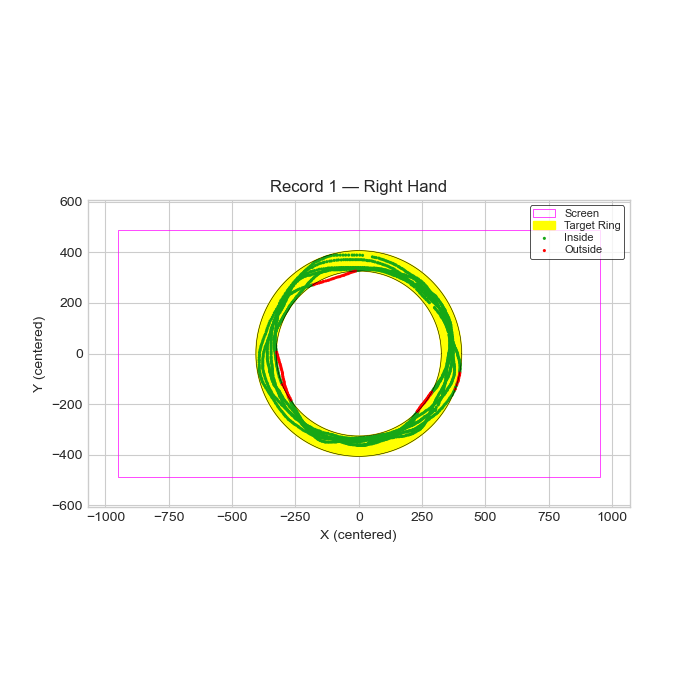

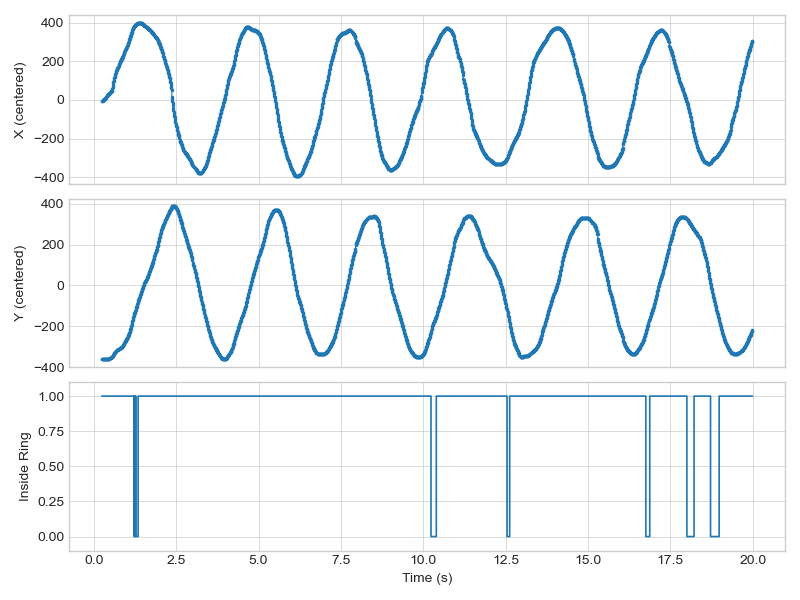


=== RECORD 2 ===


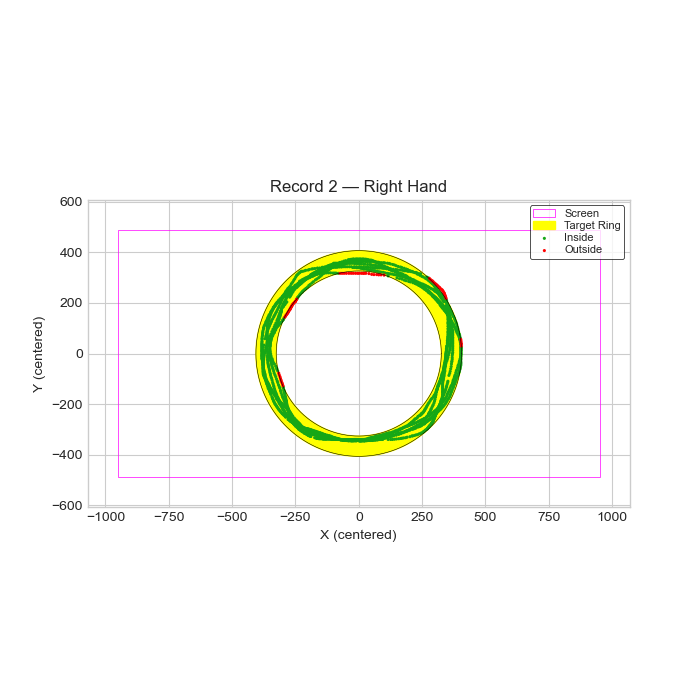

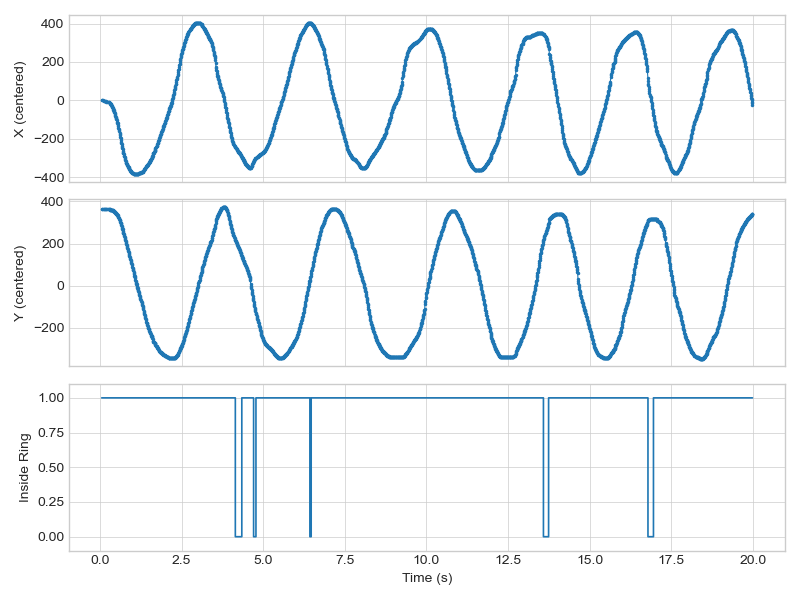


=== RECORD 3 ===


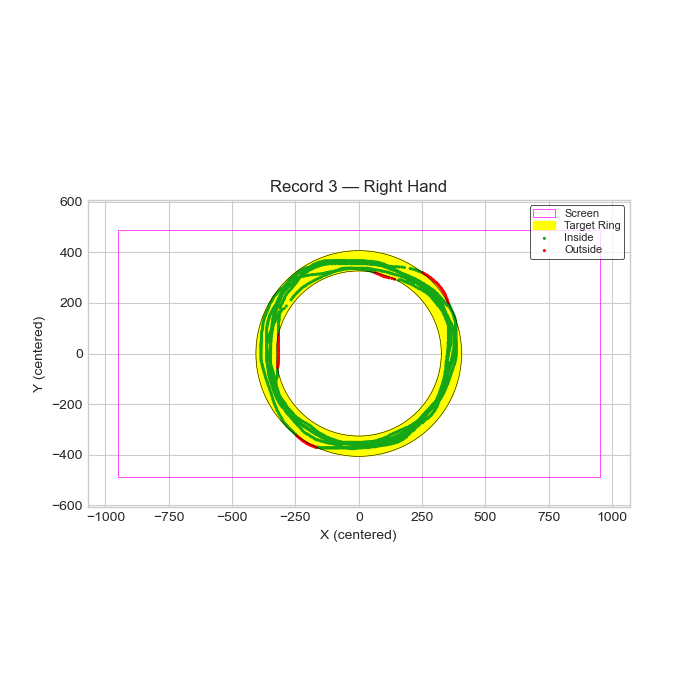

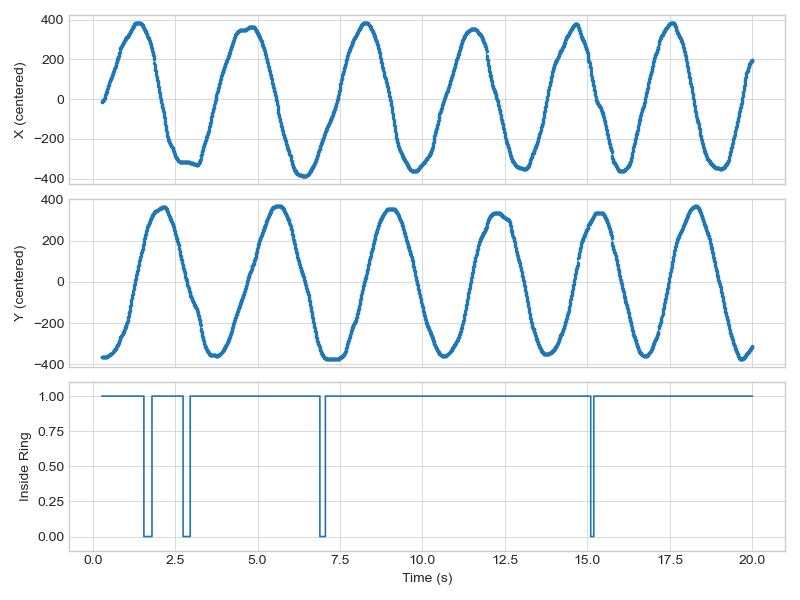


=== RECORD 4 ===


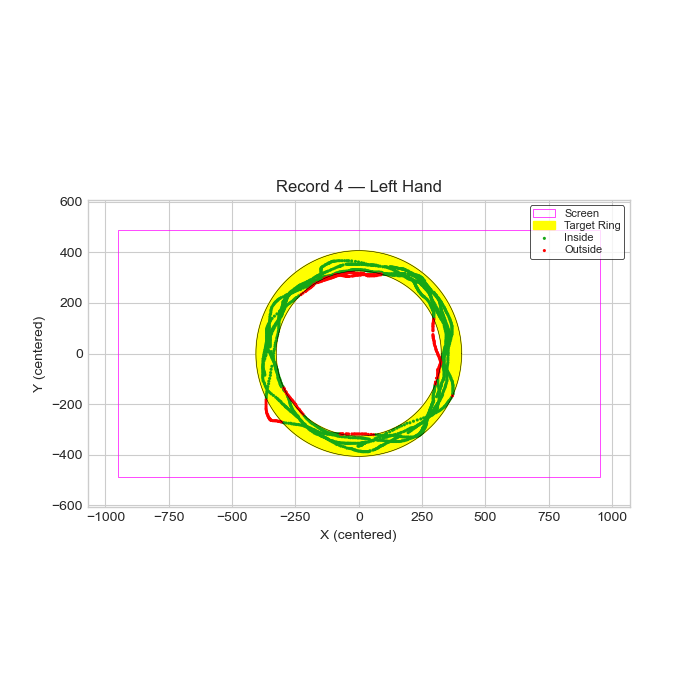

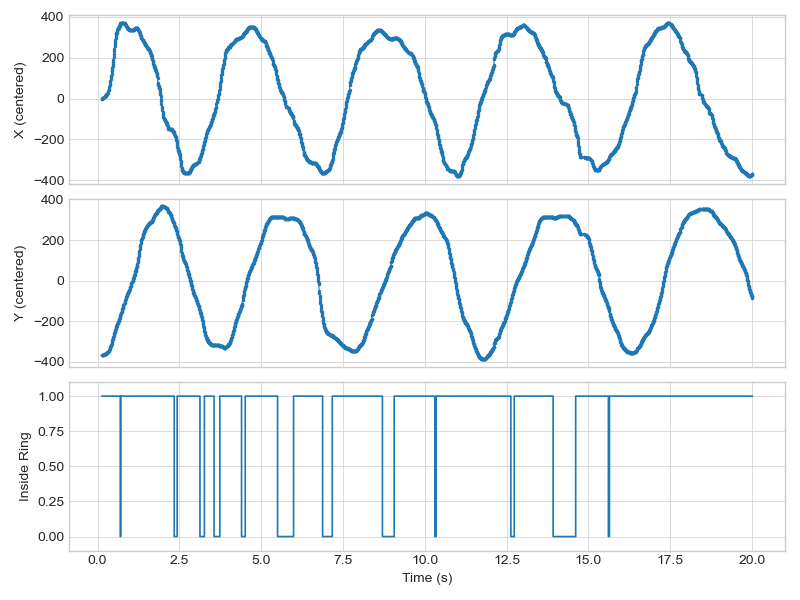


=== RECORD 5 ===


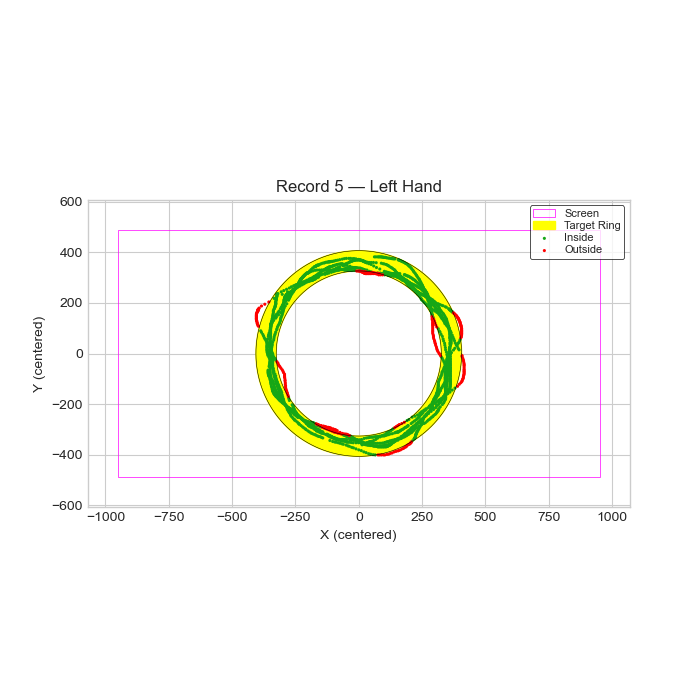

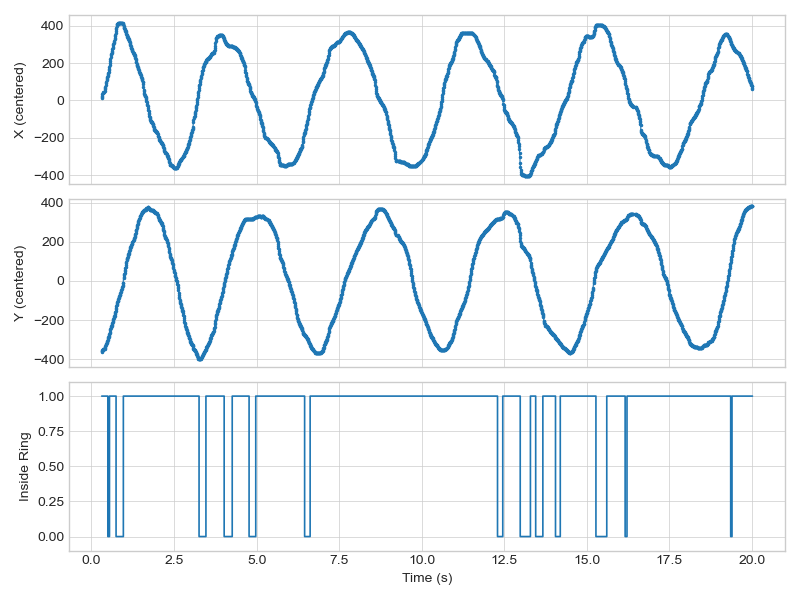


=== RECORD 6 ===


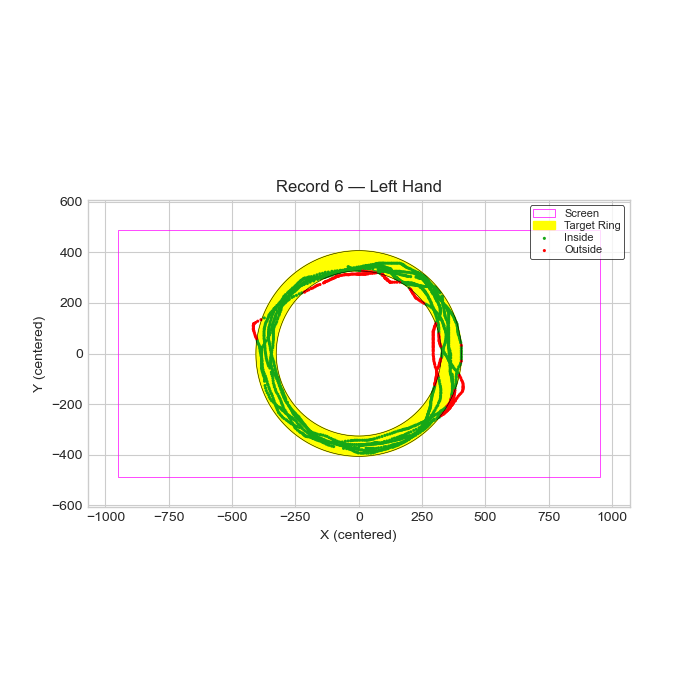

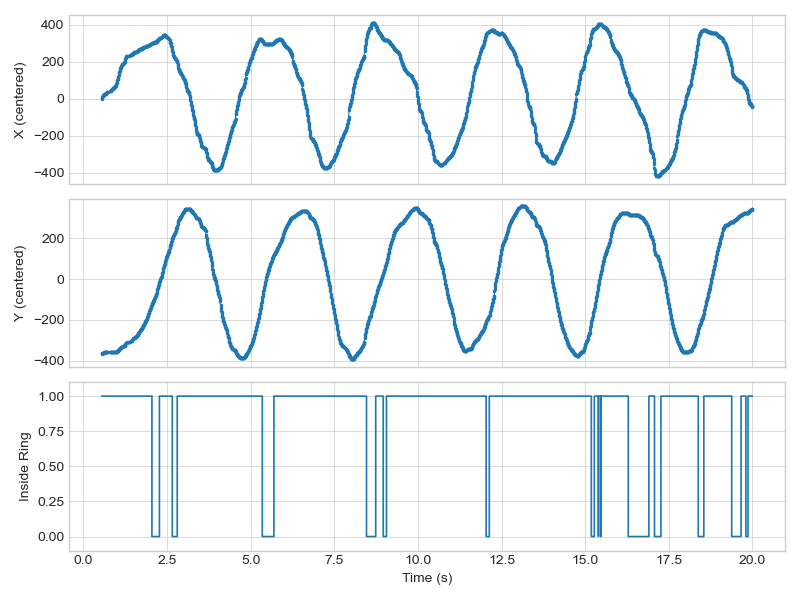

In [14]:
# =====================================================================
# README — How to use this section
# =====================================================================
# This section processes own generated mouse trajectory recordings from MouseReMoCo.
#
# TASK STRUCTURE:
#   • 6 cycles ("records")
#   • Each cycle lasts ~20 seconds ON, then ~20 seconds OFF
#   • Cycles 1–3  → Right Hand
#   • Cycles 4–6  → Left Hand
#   • Direction : Clockwise
#
# =====================================================================



# =====================================================================
# SECTION 1 — MARKER FILE  →  METADATA  →  CYCLE TIMES
# =====================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

print("=== LOADING MARKERS ===")

markers_raw = []

with open("data/record_1/001MoDe_R1.marker.csv", "r") as f:
    for line in f:
        L = line.strip()
        if not L:
            continue

        # Header (semicolon fields)
        if ";" in L and "," not in L:
            markers_raw.append(L.split(";"))
            continue

        # Timestamped events (comma-separated)
        if "," in L:
            markers_raw.append([p.strip() for p in L.split(",")])
            continue

        # Summary rows (space-separated)
        markers_raw.append(L.split())

print("Loaded", len(markers_raw), "marker rows")



# =====================================================================
# EXTRACT METADATA
# =====================================================================
header_line = markers_raw[0]
metadata = {}

for p in header_line:
    if "=" in p:
        k, v = p.split("=", 1)
        v = v.replace("java.awt.Color", "")
        metadata[k.strip()] = v.strip()

def auto(v):
    try:
        return float(v) if "." in v else int(v)
    except:
        return v

metadata_clean = {k: auto(v) for k, v in metadata.items()}

print("\n=== METADATA ===")
for k, v in metadata_clean.items():
    print(f"{k:20s} = {v}")



# =====================================================================
# EXTRACT CYCLE START/STOP
# =====================================================================
starts, stops = [], []

for row in markers_raw:
    if len(row) < 3:
        continue

    ts = row[1]
    event = row[2]

    if not ts.isdigit():
        continue

    t = int(ts)

    if "DoRecord" in event:
        starts.append(t)
    if "DoPause" in event:
        stops.append(t)

cycles = list(zip(starts, stops))

print("\n=== CYCLES DETECTED ===")
for i, (s, e) in enumerate(cycles):
    print(f"Cycle {i+1}: {s}  →  {e}   ({(e-s)/1000:.2f}s)")



# =====================================================================
# EXTRACT SCREEN + TASK PARAMETERS
# =====================================================================
screen_w = metadata_clean.get("screenWidth", 1902)
screen_h = metadata_clean.get("screenHeight", 973)
centerX  = metadata_clean.get("centerX", screen_w/2)
centerY  = metadata_clean.get("centerY", screen_h/2)

R_out  = metadata_clean.get("externalRadius", 406)
R_in   = metadata_clean.get("internalRadius", 326)
R_task = metadata_clean.get("taskRadius", 365.5)

print("\n=== TASK GEOMETRY ===")
print("Screen:", screen_w, "x", screen_h)
print("Center:", centerX, centerY)
print("Radii → Inner:", R_in, "Outer:", R_out, "Task:", R_task)



# =====================================================================
# SECTION 2 — LOAD MOUSE DATA
# =====================================================================
print("\n=== LOADING MOUSE DATA ===")

df = pd.read_csv("data/record_1/001MoDe_R1.csv", skiprows=4, header=None)
df = df.astype(float)
df.columns = ["timestamp", "x", "y", "inTarget"]

print("Mouse samples:", df.shape, "rows")

# Normalize timestamps
T0 = int(df["timestamp"].iloc[0])
df["t"] = (df["timestamp"] - T0) / 1000.0



# =====================================================================
# SECTION 3 — GEOMETRY (RINGS)
# =====================================================================
theta = np.linspace(0, 2*np.pi, 600)
x_outer = R_out * np.cos(theta)
y_outer = R_out * np.sin(theta)
x_inner = R_in  * np.cos(theta)
y_inner = R_in  * np.sin(theta)

xs_ring = np.concatenate([x_outer, x_inner[::-1]])
ys_ring = np.concatenate([y_outer, y_inner[::-1]])



# =====================================================================
# SECTION 4 — SPLIT DATASET INTO CYCLES
# =====================================================================
cycle_dfs = []
for (start, end) in cycles:
    d = df[(df.timestamp >= start) & (df.timestamp <= end)].copy()
    d["t_cycle"] = (d["timestamp"] - start) / 1000.0
    cycle_dfs.append(d)



# =====================================================================
# SECTION 5 — PLOT ALL SIX RECORDS
# =====================================================================
for i, d in enumerate(cycle_dfs):

    print(f"\n=== RECORD {i+1} ===")

    # Hand assignment
    hand = "Right Hand" if i < 3 else "Left Hand"

    # ----------------------------------------
    # CIRCULAR TRAJECTORY
    # ----------------------------------------
    fig = plt.figure(figsize=(7,7))
    ax = plt.gca()

    # SCREEN rectangle
    screen_rect = patches.Rectangle(
        (-centerX, -centerY),
        screen_w,
        screen_h,
        linewidth=0.5,
        edgecolor="magenta",
        facecolor="none",
        label="Screen")
    ax.add_patch(screen_rect)

    # Yellow ring
    ax.fill(xs_ring, ys_ring, color="#FFFF00", alpha=1.0, label="Target Ring")
    ax.plot(x_outer, y_outer, color="black", linewidth=0.4)
    ax.plot(x_inner, y_inner, color="black", linewidth=0.4)

    # Mouse trajectory
    x = d["x"].values - centerX
    y = d["y"].values - centerY
    r = np.hypot(x, y)
    inside = (r >= R_in) & (r <= R_out)

    ax.scatter(x[inside],  y[inside],  s=5, c="#16A716", edgecolors="none", label="Inside")
    ax.scatter(x[~inside], y[~inside], s=5, c="#FF0000", edgecolors="none", label="Outside")

    pad = 120
    ax.set_xlim(-centerX - pad, centerX + pad)
    ax.set_ylim(-centerY - pad, centerY + pad)
    ax.set_aspect("equal")

    plt.title(f"Record {i+1} — {hand}")
    plt.xlabel("X (centered)")
    plt.ylabel("Y (centered)")

    leg = ax.legend(loc="upper right", fontsize=8, frameon=True, fancybox=True,
                    borderpad=0.3, labelspacing=0.2)
    leg.get_frame().set_edgecolor("black")
    leg.get_frame().set_linewidth(0.6)

    plt.show()


    # ----------------------------------------
    # TIME SERIES
    # ----------------------------------------
    fig_ts, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 6))

    axs[0].plot(d["t_cycle"], x, marker='.', markersize=3, linewidth=0.8)
    axs[0].set_ylabel("X (centered)")
    axs[0].grid(True, linewidth=0.5)

    axs[1].plot(d["t_cycle"], y, marker='.', markersize=3, linewidth=0.8)
    axs[1].set_ylabel("Y (centered)")
    axs[1].grid(True, linewidth=0.5)

    axs[2].step(d["t_cycle"], inside.astype(int), where='mid', linewidth=1.2)
    axs[2].set_ylabel("Inside Ring")
    axs[2].set_ylim(-0.1, 1.1)
    axs[2].set_xlabel("Time (s)")
    axs[2].grid(True, linewidth=0.5)

    plt.tight_layout()
    plt.show()

<a id="4-title"></a>
# 4. [Discussion, limitations, and conclusions](#total-title)

=== LOADING MARKERS ===
Loaded 25 marker rows

=== METADATA ===
screenWidth 1104;screenHeight 661;cornerX 302;cornerY 80;centerX 552;centerY 330;externalRadius 250;internalRadius 170;borderRadius 1;cursorRadius 16;indexOfDifficulty 28.00696429476858;taskRadius 209.5;taskTolerance 47;borderColor java.awt.Color[r = 255
g                    = 255
b                    = 0];autoStart 3600;cycleMaxNumber 6;cycleDuration 20;software LSL-mouse;version 1.2.0rc5;task CircularTarget;isWithLSL false

=== CYCLES DETECTED ===
Cycle 1: 1616776712333  →  1616776732336   (20.00s)
Cycle 2: 1616776752340  →  1616776772351   (20.01s)
Cycle 3: 1616776792372  →  1616776812386   (20.01s)
Cycle 4: 1616776832390  →  1616776852404   (20.01s)
Cycle 5: 1616776872419  →  1616776892433   (20.01s)

=== TASK GEOMETRY ===
Screen: 1104 x 661
Center: 552.0 330.5
Radii → Inner: 170 Outer: 250 Task: 209.5

=== LOADING MOUSE DATA ===
Mouse samples: 19593 rows

=== Per-trial metrics ===
 trial  n_points  mean_speed  max_spe

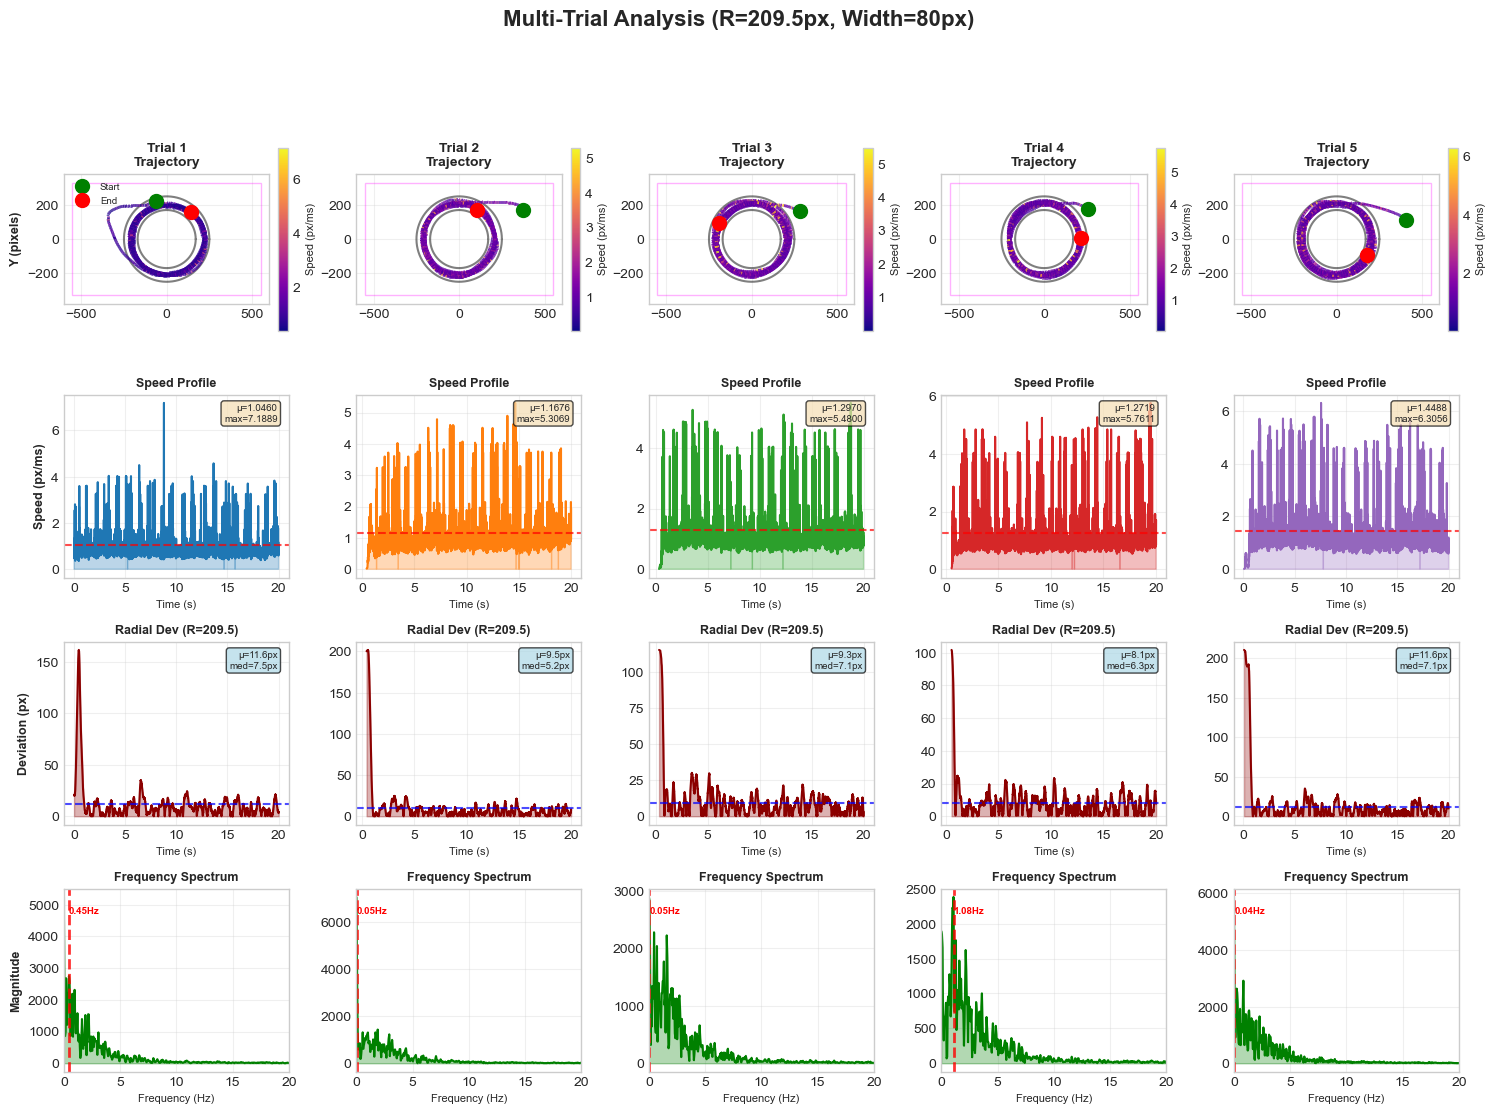

In [ ]:
# =====================================================================
# COMPLETE MOUSEREMOCO ANALYSIS PIPELINE
# =====================================================================
# This combines data loading, processing, and enhanced visualization
# =====================================================================

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.signal as signal
from math import degrees, atan2
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection

# =====================================================================
# SECTION 1 — LOAD MARKERS AND EXTRACT METADATA
# =====================================================================
print("=== LOADING MARKERS ===")

markers_raw = []
with open("data/001MoDe_R1.marker.csv", "r") as f:
    for line in f:
        L = line.strip()
        if not L:
            continue
        if ";" in L and "," not in L:
            markers_raw.append(L.split(";"))
            continue
        if "," in L:
            markers_raw.append([p.strip() for p in L.split(",")])
            continue
        markers_raw.append(L.split())

print("Loaded", len(markers_raw), "marker rows")

# Extract metadata
header_line = markers_raw[0]
metadata = {}
for p in header_line:
    if "=" in p:
        k, v = p.split("=", 1)
        v = v.replace("java.awt.Color", "")
        metadata[k.strip()] = v.strip()

def auto(v):
    try:
        return float(v) if "." in v else int(v)
    except:
        return v

metadata_clean = {k: auto(v) for k, v in metadata.items()}

print("\n=== METADATA ===")
for k, v in metadata_clean.items():
    print(f"{k:20s} = {v}")

# Extract cycle start/stop times
starts, stops = [], []
for row in markers_raw:
    if len(row) < 3:
        continue
    ts = row[1]
    event = row[2]
    if not isinstance(ts, str) or not ts.isdigit():
        continue
    t = int(ts)
    if "DoRecord" in event:
        starts.append(t)
    if "DoPause" in event:
        stops.append(t)

cycles = list(zip(starts, stops))

print("\n=== CYCLES DETECTED ===")
for i, (s, e) in enumerate(cycles):
    print(f"Cycle {i+1}: {s}  →  {e}   ({(e-s)/1000:.2f}s)")

# =====================================================================
# EXTRACT TASK PARAMETERS
# =====================================================================
screen_w = metadata_clean.get("screenWidth", 1104)
screen_h = metadata_clean.get("screenHeight", 661)
centerX  = metadata_clean.get("centerX", screen_w/2)
centerY  = metadata_clean.get("centerY", screen_h/2)

R_out  = metadata_clean.get("externalRadius", 250)
R_in   = metadata_clean.get("internalRadius", 170)
R_task = metadata_clean.get("taskRadius", 209.5)

print("\n=== TASK GEOMETRY ===")
print("Screen:", screen_w, "x", screen_h)
print("Center:", centerX, centerY)
print("Radii → Inner:", R_in, "Outer:", R_out, "Task:", R_task)

# =====================================================================
# SECTION 2 — LOAD MOUSE DATA
# =====================================================================
print("\n=== LOADING MOUSE DATA ===")

df = pd.read_csv("data/001MoDe_R1.csv", skiprows=4, header=None)
df = df.astype(float)
df.columns = ["timestamp", "x", "y", "inTarget"]

print("Mouse samples:", df.shape[0], "rows")

# Normalize timestamps
T0 = int(df["timestamp"].iloc[0])
df["t"] = (df["timestamp"] - T0) / 1000.0

# =====================================================================
# SECTION 3 — SPLIT INTO CYCLES AND COMPUTE KINEMATICS
# =====================================================================
cycle_dfs = []
for start, end in cycles:
    d = df[(df.timestamp >= start) & (df.timestamp <= end)].copy()
    d["t_cycle"] = (d["timestamp"] - start) / 1000.0
    d["x_c"] = d["x"] - centerX
    d["y_c"] = d["y"] - centerY
    d["radius"] = np.sqrt(d["x_c"]**2 + d["y_c"]**2)
    d["angle"] = np.arctan2(-d["y_c"], d["x_c"])  # Negative y for screen coords
    cycle_dfs.append(d)

# =====================================================================
# COMPUTE KINEMATICS
# =====================================================================
def compute_kinematics(d):
    if len(d) < 2:
        d["vx"] = np.nan
        d["vy"] = np.nan
        d["speed"] = np.nan
        d["radius_smooth"] = d["radius"].values if "radius" in d else np.nan
        d["radial_dev"] = np.nan
        return d
    
    t_ms = d["timestamp"].values.astype(float)
    vx = np.gradient(d["x"].values, t_ms)
    vy = np.gradient(d["y"].values, t_ms)
    speed = np.sqrt(vx**2 + vy**2)
    
    # Smoothing
    win = min(101, max(5, (len(speed)//2)*2+1))
    try:
        speed_s = signal.savgol_filter(speed, win_length=win, polyorder=3)
        radius_s = signal.savgol_filter(d["radius"].values, win_length=win, polyorder=3)
    except:
        speed_s = speed
        radius_s = d["radius"].values
    
    d["vx"] = vx
    d["vy"] = vy
    d["speed"] = speed_s
    d["radius_smooth"] = radius_s
    d["radial_dev"] = np.abs(radius_s - R_task)
    return d

for i in range(len(cycle_dfs)):
    cycle_dfs[i] = compute_kinematics(cycle_dfs[i])

# =====================================================================
# COMPUTE FFT ON RADIAL DEVIATION
# =====================================================================
def radial_fft(d):
    rd = d["radial_dev"].values
    t = d["t_cycle"].values
    if len(rd) < 8:
        return None
    dt = np.median(np.diff(t))
    y = rd - np.mean(rd)
    w = signal.windows.hann(len(y))
    y = y * w
    N = len(y)
    yf = np.abs(np.fft.rfft(y))
    xf = np.fft.rfftfreq(N, d=dt)
    return xf, yf

fft_results = [radial_fft(d) for d in cycle_dfs]

# =====================================================================
# COMPUTE PER-TRIAL METRICS
# =====================================================================
metrics = []
for i, d in enumerate(cycle_dfs):
    if len(d) == 0:
        metrics.append({"trial": i+1, "n_points": 0})
        continue
    
    mean_speed = float(np.nanmean(d["speed"]))
    max_speed = float(np.nanmax(d["speed"]))
    mean_radial = float(np.nanmean(d["radial_dev"]))
    median_radial = float(np.nanmedian(d["radial_dev"]))
    time_inside = float(np.sum((d["radius"]>=R_in)&(d["radius"]<=R_out)) / len(d))
    
    ang = np.unwrap(d["angle"].values)
    drift_deg = float(degrees(ang[-1] - ang[0])) if len(ang)>1 else 0.0
    
    fft_res = fft_results[i]
    dom_f = float(np.nan)
    if fft_res is not None:
        xf, yf = fft_res
        if len(xf) > 1:
            idx = np.argmax(yf[1:]) + 1
            dom_f = float(xf[idx])
    
    metrics.append({
        "trial": i+1,
        "n_points": len(d),
        "mean_speed": mean_speed,
        "max_speed": max_speed,
        "mean_radial_dev": mean_radial,
        "median_radial_dev": median_radial,
        "time_inside_ratio": time_inside,
        "drift_deg": drift_deg,
        "dominant_freq_hz": dom_f
    })

metrics_df = pd.DataFrame(metrics)

# =====================================================================
# COMPUTE COMPOSITE SCORE
# =====================================================================
def norm_inv(arr):
    a = np.array(arr, dtype=float)
    a_nonan = a[~np.isnan(a)]
    if len(a_nonan) == 0:
        return np.full_like(a, np.nan)
    vmin, vmax = a_nonan.min(), a_nonan.max()
    if vmax == vmin:
        return np.ones_like(a)
    return 1.0 - (a - vmin)/(vmax - vmin)

def norm(arr):
    a = np.array(arr, dtype=float)
    a_nonan = a[~np.isnan(a)]
    if len(a_nonan) == 0:
        return np.full_like(a, np.nan)
    vmin, vmax = a_nonan.min(), a_nonan.max()
    if vmax == vmin:
        return np.ones_like(a)
    return (a - vmin)/(vmax - vmin)

m = metrics_df.copy()
comp_radial = norm_inv(m["mean_radial_dev"].values)
comp_time_in = norm(m["time_inside_ratio"].values)
comp_speed = norm(1.0/(1.0 + m["mean_speed"].values))
comp_drift = norm_inv(np.abs(m["drift_deg"].values))

w1, w2, w3, w4 = 0.35, 0.30, 0.20, 0.15
m["composite_score"] = w1*comp_radial + w2*comp_time_in + w3*comp_speed + w4*comp_drift

print("\n=== Per-trial metrics ===")
print(metrics_df.round(4).to_string(index=False))

print("\n=== Composite scores ===")
print(m[["trial", "composite_score"]].round(4).to_string(index=False))

# =====================================================================
# VISUALIZATIONS
# =====================================================================

plt.style.use('seaborn-v0_8-whitegrid')
colors_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Precompute ring coordinates
theta = np.linspace(0, 2*np.pi, 600)
x_outer = R_out * np.cos(theta)
y_outer = R_out * np.sin(theta)
x_inner = R_in * np.cos(theta)
y_inner = R_in * np.sin(theta)

# =====================================================================
# FIGURE 1: Multi-Trial Overview
# =====================================================================
n_trials = len(cycle_dfs)
fig1 = plt.figure(figsize=(18, 12))
gs = fig1.add_gridspec(4, n_trials, hspace=0.35, wspace=0.3)

for i, d in enumerate(cycle_dfs):
    if len(d) == 0:
        continue
    
    # Row 1: Trajectories with Speed Heatmap
    ax1 = fig1.add_subplot(gs[0, i])
    
    # Draw screen boundary
    screen = patches.Polygon(list(zip(screen_x, screen_y)), closed=True, 
                            linewidth=1, edgecolor="magenta", facecolor="none", alpha=0.3)
    ax1.add_patch(screen)
    
    ax1.plot(x_outer, y_outer, 'k-', linewidth=1.5, alpha=0.5)
    ax1.plot(x_inner, y_inner, 'k-', linewidth=1.5, alpha=0.5)
    
    # Speed-colored trajectory
    x_vals = d["x_c"].values
    y_vals = d["y_c"].values
    speed_vals = d["speed"].values
    
    points = np.array([x_vals, y_vals]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='plasma', linewidth=2)
    lc.set_array(speed_vals[:-1])
    ax1.add_collection(lc)
    
    ax1.plot(x_vals[0], y_vals[0], 'go', markersize=10, label='Start', zorder=5)
    ax1.plot(x_vals[-1], y_vals[-1], 'ro', markersize=10, label='End', zorder=5)
    
    ax1.set_aspect('equal')
    ax1.set_xlim(-centerX-50, centerX+50)
    ax1.set_ylim(-centerY-50, centerY+50)
    ax1.set_title(f'Trial {i+1}\nTrajectory', fontsize=10, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    if i == 0:
        ax1.set_ylabel('Y (pixels)', fontsize=9, fontweight='bold')
        ax1.legend(loc='upper left', fontsize=7)
    
    cbar = plt.colorbar(lc, ax=ax1, fraction=0.046, pad=0.04)
    cbar.set_label('Speed (px/ms)', fontsize=8)
    
    # Row 2: Speed Profile
    ax2 = fig1.add_subplot(gs[1, i])
    t_cycle = d["t_cycle"].values
    speed = d["speed"].values
    
    ax2.plot(t_cycle, speed, color=colors_palette[i], linewidth=1.5)
    ax2.fill_between(t_cycle, speed, alpha=0.3, color=colors_palette[i])
    
    mean_speed = np.nanmean(speed)
    max_speed = np.nanmax(speed)
    ax2.axhline(y=mean_speed, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax2.text(0.95, 0.95, f'μ={mean_speed:.4f}\nmax={max_speed:.4f}',
             transform=ax2.transAxes, fontsize=7, va='top', ha='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    ax2.set_title('Speed Profile', fontsize=9, fontweight='bold')
    ax2.set_xlabel('Time (s)', fontsize=8)
    ax2.grid(True, alpha=0.3)
    if i == 0:
        ax2.set_ylabel('Speed (px/ms)', fontsize=9, fontweight='bold')
    
    # Row 3: Radial Deviation
    ax3 = fig1.add_subplot(gs[2, i])
    radial_dev = d["radial_dev"].values
    
    ax3.plot(t_cycle, radial_dev, color='darkred', linewidth=1.5)
    ax3.fill_between(t_cycle, radial_dev, alpha=0.3, color='darkred')
    
    mean_dev = np.nanmean(radial_dev)
    median_dev = np.nanmedian(radial_dev)
    ax3.axhline(y=mean_dev, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
    ax3.text(0.95, 0.95, f'μ={mean_dev:.1f}px\nmed={median_dev:.1f}px',
             transform=ax3.transAxes, fontsize=7, va='top', ha='right',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    ax3.set_title(f'Radial Dev (R={R_task:.1f})', fontsize=9, fontweight='bold')
    ax3.set_xlabel('Time (s)', fontsize=8)
    ax3.grid(True, alpha=0.3)
    if i == 0:
        ax3.set_ylabel('Deviation (px)', fontsize=9, fontweight='bold')
    
    # Row 4: FFT Spectrum
    ax4 = fig1.add_subplot(gs[3, i])
    res = fft_results[i]
    
    if res is not None:
        xf, yf = res
        ax4.plot(xf, yf, color='green', linewidth=1.5)
        ax4.fill_between(xf, yf, alpha=0.3, color='green')
        
        if len(xf) > 1:
            idx = np.argmax(yf[1:]) + 1
            dom_f = xf[idx]
            ax4.axvline(x=dom_f, color='red', linestyle='--', linewidth=2, alpha=0.8)
            ax4.text(dom_f, max(yf)*0.9, f'{dom_f:.2f}Hz',
                    fontsize=7, color='red', fontweight='bold')
        
        ax4.set_xlim(0, min(20, xf.max()))
    else:
        ax4.text(0.5, 0.5, 'No FFT', transform=ax4.transAxes,
                ha='center', va='center', fontsize=9)
    
    ax4.set_title('Frequency Spectrum', fontsize=9, fontweight='bold')
    ax4.set_xlabel('Frequency (Hz)', fontsize=8)
    ax4.grid(True, alpha=0.3)
    if i == 0:
        ax4.set_ylabel('Magnitude', fontsize=9, fontweight='bold')

plt.suptitle(f'Multi-Trial Analysis (R={R_task:.1f}px, Width={R_out-R_in}px)', 
             fontsize=16, fontweight='bold', y=0.995)
#plt.savefig('figs/trials_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# =====================================================================
# FIGURE 2: Performance Metrics
# =====================================================================
fig2, axes = plt.subplots(2, 3, figsize=(16, 10))

trial_nums = metrics_df["trial"].values
colors_trials = plt.cm.viridis(np.linspace(0.2, 0.9, len(trial_nums)))

# Mean Speed
ax = axes[0, 0]
ax.bar(trial_nums, metrics_df["mean_speed"], color=colors_trials, 
       edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_title('Mean Speed', fontsize=12, fontweight='bold')
ax.set_ylabel('Speed (px/ms)', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(trial_nums)

# Max Speed
ax = axes[0, 1]
ax.bar(trial_nums, metrics_df["max_speed"], color=colors_trials,
       edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_title('Max Speed', fontsize=12, fontweight='bold')
ax.set_ylabel('Speed (px/ms)', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(trial_nums)

# Radial Deviation
ax = axes[0, 2]
x = np.arange(len(trial_nums))
width = 0.35
ax.bar(x - width/2, metrics_df["mean_radial_dev"], width, label='Mean', 
       color='skyblue', edgecolor='black', linewidth=1.5)
ax.bar(x + width/2, metrics_df["median_radial_dev"], width, label='Median',
       color='lightcoral', edgecolor='black', linewidth=1.5)
ax.set_title('Radial Deviation', fontsize=12, fontweight='bold')
ax.set_ylabel('Deviation (px)', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(trial_nums)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Time Inside
ax = axes[1, 0]
time_inside = metrics_df["time_inside_ratio"] * 100
bars = ax.bar(trial_nums, time_inside, edgecolor='black', linewidth=1.5, alpha=0.8)
for bar, val in zip(bars, time_inside):
    if val >= 95:
        bar.set_color('green')
    elif val >= 90:
        bar.set_color('yellow')
    else:
        bar.set_color('red')
ax.axhline(y=95, color='green', linestyle='--', linewidth=2, alpha=0.5)
ax.set_title('Target Adherence', fontsize=12, fontweight='bold')
ax.set_ylabel('Time Inside (%)', fontsize=11, fontweight='bold')
ax.set_ylim([0, 105])
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(trial_nums)

# Angular Drift
ax = axes[1, 1]
ax.bar(trial_nums, np.abs(metrics_df["drift_deg"]), color=colors_trials,
       edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_title('Angular Drift', fontsize=12, fontweight='bold')
ax.set_ylabel('Degrees', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(trial_nums)

# Dominant Frequency
ax = axes[1, 2]
ax.bar(trial_nums, metrics_df["dominant_freq_hz"], color=colors_trials,
       edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_title('Dominant Frequency', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency (Hz)', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(trial_nums)

plt.suptitle('Performance Metrics Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
#plt.savefig('performance_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Analysis complete! Figures saved.")

=== LOADING MARKERS ===
Loaded 25 marker rows

=== METADATA ===
screenWidth 1104;screenHeight 661;cornerX 302;cornerY 80;centerX 552;centerY 330;externalRadius 250;internalRadius 170;borderRadius 1;cursorRadius 16;indexOfDifficulty 28.00696429476858;taskRadius 209.5;taskTolerance 47;borderColor java.awt.Color[r = 255
g                    = 255
b                    = 0];autoStart 3600;cycleMaxNumber 6;cycleDuration 20;software LSL-mouse;version 1.2.0rc5;task CircularTarget;isWithLSL false

=== TASK GEOMETRY ===
Screen: 1104 x 661
Center: 552 330
Radii → Inner: 170 Outer: 250 Task: 209.5

=== LOADING MOUSE DATA ===
Mouse samples: 19593 rows

Found X≈0 split points at indices: [ 3972  7871 11770 15655 19592]
Number of split points: 5
Group 1: Indices [0, 3971], Length: 3972
Group 2: Indices [3973, 7870], Length: 3898
Group 3: Indices [7872, 11769], Length: 3898
Group 4: Indices [11771, 15654], Length: 3884
Group 5: Indices [15656, 19591], Length: 3936

Successfully split into 5 groups

==

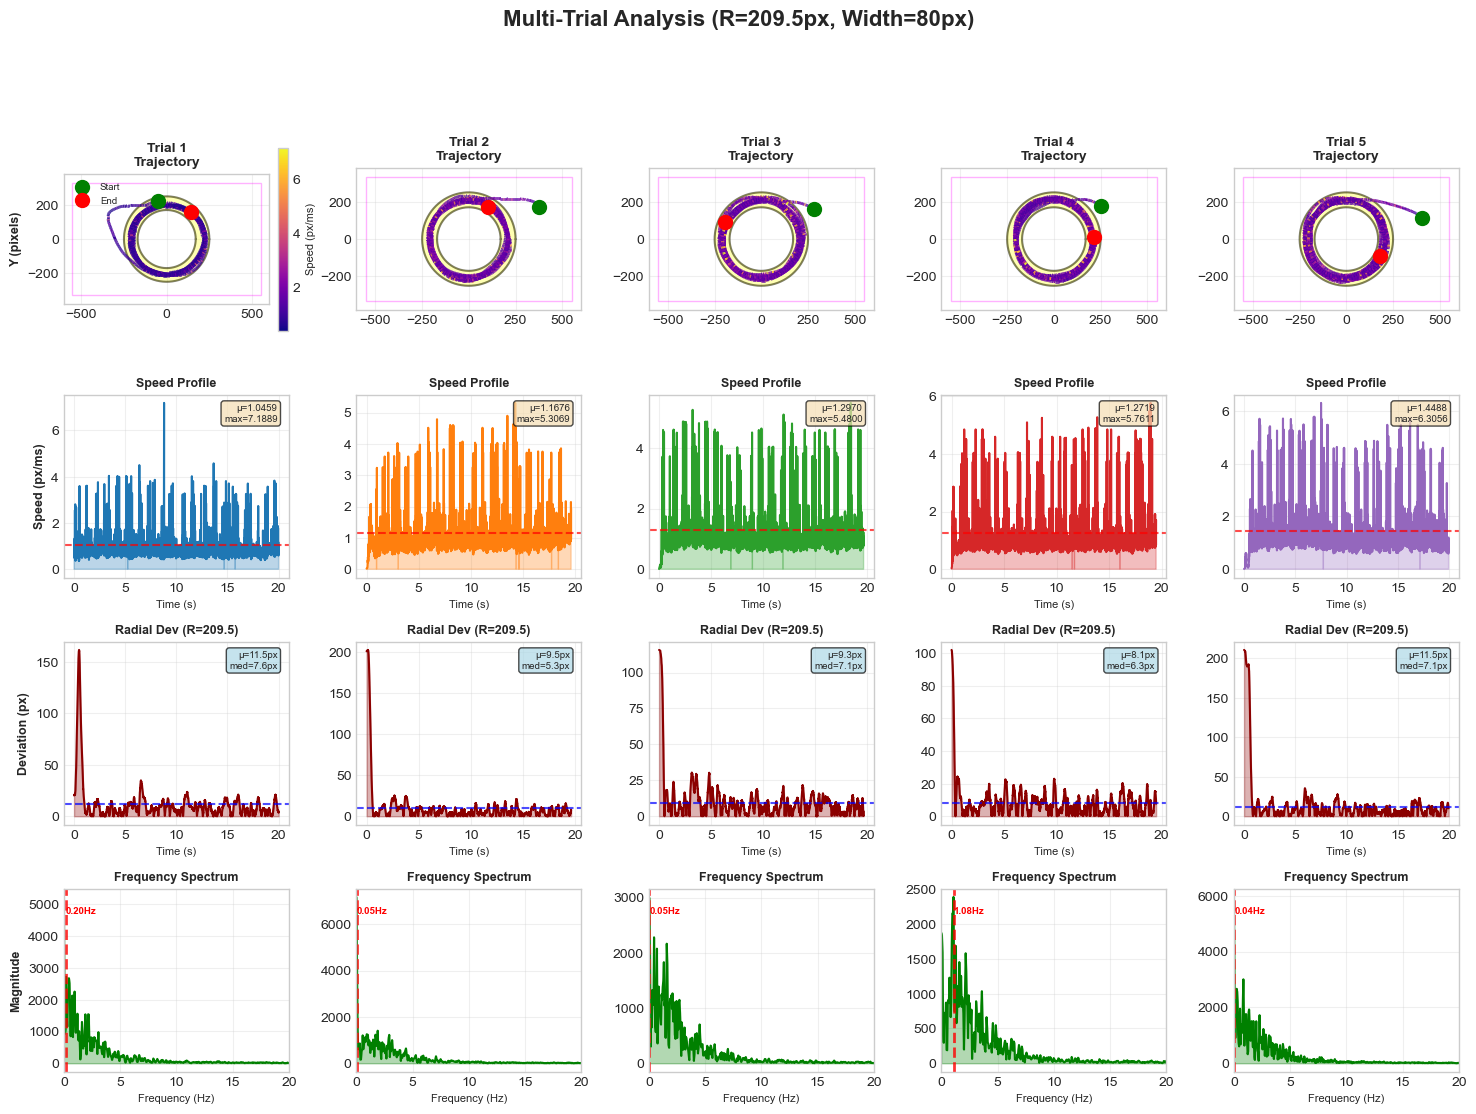

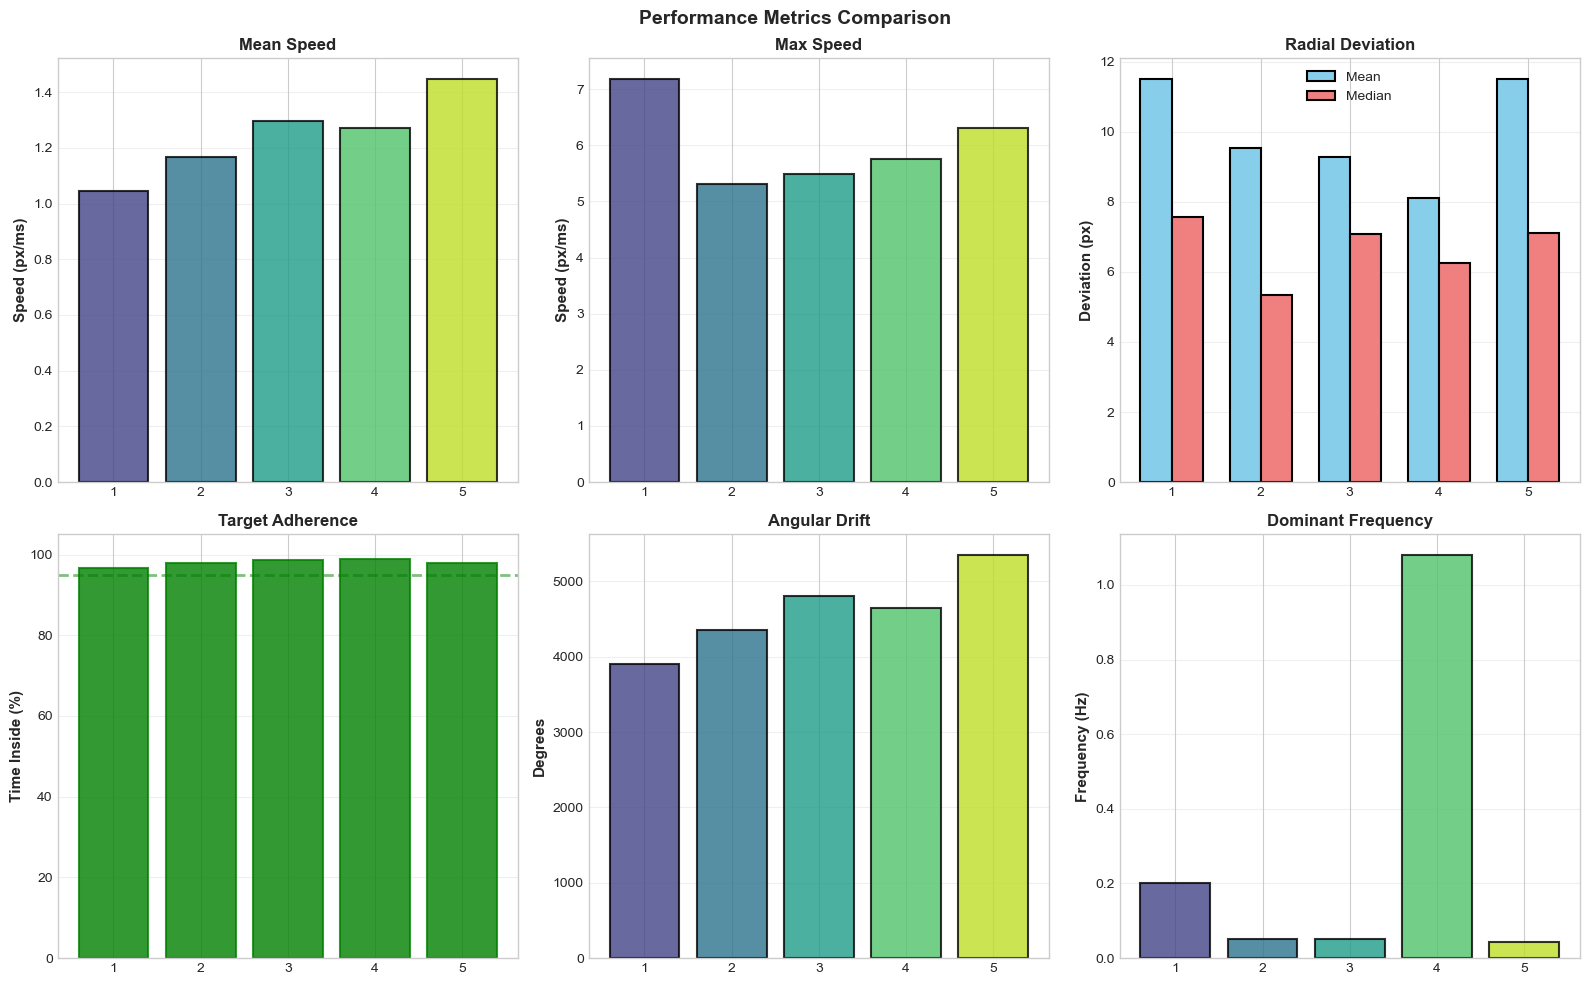


✅ Analysis complete! Figures saved.
   • Detected 5 trials using X≈0 method
   • Generated multi_trial_overview.png
   • Generated performance_metrics.png


In [4]:
# =====================================================================
# COMPLETE MOUSEREMOCO ANALYSIS PIPELINE
# Using X≈0 detection for cycle splitting
# =====================================================================

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Wedge
import scipy.signal as signal
from math import degrees, atan2
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection

# =====================================================================
# SECTION 1 — LOAD MARKERS AND EXTRACT METADATA
# =====================================================================
print("=== LOADING MARKERS ===")

markers_raw = []
with open("data/001MoDe_R1.marker.csv", "r") as f:
    for line in f:
        L = line.strip()
        if not L:
            continue
        if ";" in L and "," not in L:
            markers_raw.append(L.split(";"))
            continue
        if "," in L:
            markers_raw.append([p.strip() for p in L.split(",")])
            continue
        markers_raw.append(L.split())

print("Loaded", len(markers_raw), "marker rows")

# Extract metadata
header_line = markers_raw[0]
metadata = {}
for p in header_line:
    if "=" in p:
        k, v = p.split("=", 1)
        v = v.replace("java.awt.Color", "")
        metadata[k.strip()] = v.strip()

def auto(v):
    try:
        return float(v) if "." in v else int(v)
    except:
        return v

metadata_clean = {k: auto(v) for k, v in metadata.items()}

print("\n=== METADATA ===")
for k, v in metadata_clean.items():
    print(f"{k:20s} = {v}")

# =====================================================================
# EXTRACT TASK PARAMETERS
# =====================================================================
screen_w = metadata_clean.get("screenWidth", 1104)
screen_h = metadata_clean.get("screenHeight", 661)
centerX  = metadata_clean.get("centerX", 552)
centerY  = metadata_clean.get("centerY", 330)

R_out  = metadata_clean.get("externalRadius", 250)
R_in   = metadata_clean.get("internalRadius", 170)
R_task = metadata_clean.get("taskRadius", 209.5)

print("\n=== TASK GEOMETRY ===")
print("Screen:", screen_w, "x", screen_h)
print("Center:", centerX, centerY)
print("Radii → Inner:", R_in, "Outer:", R_out, "Task:", R_task)

# =====================================================================
# SECTION 2 — LOAD MOUSE DATA
# =====================================================================
print("\n=== LOADING MOUSE DATA ===")

file_name = 'data/001MoDe_R1.csv'
data = np.genfromtxt(file_name, delimiter=',', skip_header=4)

time_1 = data[:, 0]
x_position = data[:, 1] - centerX  # Centered coordinates
y_position = data[:, 2] - centerY
raw_x = data[:, 1]  # Original X before centering

print("Mouse samples:", len(time_1), "rows")

# =====================================================================
# SECTION 3 — DETECT CYCLE SPLITS USING X≈0
# =====================================================================
zero_x_indices = np.where(np.abs(raw_x) < 0.5)[0]
print(f"\nFound X≈0 split points at indices: {zero_x_indices}")
print(f"Number of split points: {len(zero_x_indices)}")

# Split into groups using X≈0 markers
data_groups = []
for i in range(len(zero_x_indices)):
    if i == 0:
        start_idx = 0
        end_idx = zero_x_indices[0] - 1
    else:
        start_idx = zero_x_indices[i-1] + 1
        end_idx = zero_x_indices[i] - 1
    
    if start_idx >= end_idx:
        print(f"Warning: Invalid indices for Group {i+1}, skipping!")
        continue
    
    group = {
        'group_num': i+1,
        'start_idx': start_idx,
        'end_idx': end_idx,
        'x': x_position[start_idx:end_idx+1],
        'y': y_position[start_idx:end_idx+1],
        'time': time_1[start_idx:end_idx+1],
        'true_signal': data[:, 3][start_idx:end_idx+1]
    }
    data_groups.append(group)
    print(f"Group {i+1}: Indices [{start_idx}, {end_idx}], Length: {len(group['x'])}")

print(f"\nSuccessfully split into {len(data_groups)} groups")

# =====================================================================
# SECTION 4 — CREATE CYCLE DataFrames FOR ANALYSIS
# =====================================================================
cycle_dfs = []
for group in data_groups:
    d = pd.DataFrame({
        'timestamp': group['time'],
        'x': group['x'] + centerX,  # Convert back to absolute coords
        'y': group['y'] + centerY,
        'inTarget': group['true_signal']
    })
    
    # Add derived columns
    d['t_cycle'] = (d['timestamp'] - d['timestamp'].iloc[0]) / 1000.0
    d['x_c'] = d['x'] - centerX
    d['y_c'] = d['y'] - centerY
    d['radius'] = np.sqrt(d['x_c']**2 + d['y_c']**2)
    d['angle'] = np.arctan2(-d['y_c'], d['x_c'])  # Negative y for screen coords
    
    cycle_dfs.append(d)

# =====================================================================
# COMPUTE KINEMATICS
# =====================================================================
def compute_kinematics(d):
    if len(d) < 2:
        d["vx"] = np.nan
        d["vy"] = np.nan
        d["speed"] = np.nan
        d["radius_smooth"] = d["radius"].values
        d["radial_dev"] = np.nan
        return d
    
    t_ms = d["timestamp"].values.astype(float)
    vx = np.gradient(d["x"].values, t_ms)
    vy = np.gradient(d["y"].values, t_ms)
    speed = np.sqrt(vx**2 + vy**2)
    
    # Smoothing
    win = min(101, max(5, (len(speed)//2)*2+1))
    try:
        speed_s = signal.savgol_filter(speed, win_length=win, polyorder=3)
        radius_s = signal.savgol_filter(d["radius"].values, win_length=win, polyorder=3)
    except:
        speed_s = speed
        radius_s = d["radius"].values
    
    d["vx"] = vx
    d["vy"] = vy
    d["speed"] = speed_s
    d["radius_smooth"] = radius_s
    d["radial_dev"] = np.abs(radius_s - R_task)
    return d

for i in range(len(cycle_dfs)):
    cycle_dfs[i] = compute_kinematics(cycle_dfs[i])

# =====================================================================
# COMPUTE FFT ON RADIAL DEVIATION
# =====================================================================
def radial_fft(d):
    rd = d["radial_dev"].values
    t = d["t_cycle"].values
    if len(rd) < 8:
        return None
    dt = np.median(np.diff(t))
    y = rd - np.mean(rd)
    w = signal.windows.hann(len(y))
    y = y * w
    N = len(y)
    yf = np.abs(np.fft.rfft(y))
    xf = np.fft.rfftfreq(N, d=dt)
    return xf, yf

fft_results = [radial_fft(d) for d in cycle_dfs]

# =====================================================================
# COMPUTE PER-TRIAL METRICS
# =====================================================================
metrics = []
for i, d in enumerate(cycle_dfs):
    if len(d) == 0:
        metrics.append({"trial": i+1, "n_points": 0})
        continue
    
    mean_speed = float(np.nanmean(d["speed"]))
    max_speed = float(np.nanmax(d["speed"]))
    mean_radial = float(np.nanmean(d["radial_dev"]))
    median_radial = float(np.nanmedian(d["radial_dev"]))
    time_inside = float(np.sum((d["radius"]>=R_in)&(d["radius"]<=R_out)) / len(d))
    
    ang = np.unwrap(d["angle"].values)
    drift_deg = float(degrees(ang[-1] - ang[0])) if len(ang)>1 else 0.0
    
    fft_res = fft_results[i]
    dom_f = float(np.nan)
    if fft_res is not None:
        xf, yf = fft_res
        if len(xf) > 1:
            idx = np.argmax(yf[1:]) + 1
            dom_f = float(xf[idx])
    
    metrics.append({
        "trial": i+1,
        "n_points": len(d),
        "mean_speed": mean_speed,
        "max_speed": max_speed,
        "mean_radial_dev": mean_radial,
        "median_radial_dev": median_radial,
        "time_inside_ratio": time_inside,
        "drift_deg": drift_deg,
        "dominant_freq_hz": dom_f
    })

metrics_df = pd.DataFrame(metrics)

# =====================================================================
# COMPUTE COMPOSITE SCORE
# =====================================================================
def norm_inv(arr):
    a = np.array(arr, dtype=float)
    a_nonan = a[~np.isnan(a)]
    if len(a_nonan) == 0:
        return np.full_like(a, np.nan)
    vmin, vmax = a_nonan.min(), a_nonan.max()
    if vmax == vmin:
        return np.ones_like(a)
    return 1.0 - (a - vmin)/(vmax - vmin)

def norm(arr):
    a = np.array(arr, dtype=float)
    a_nonan = a[~np.isnan(a)]
    if len(a_nonan) == 0:
        return np.full_like(a, np.nan)
    vmin, vmax = a_nonan.min(), a_nonan.max()
    if vmax == vmin:
        return np.ones_like(a)
    return (a - vmin)/(vmax - vmin)

m = metrics_df.copy()
comp_radial = norm_inv(m["mean_radial_dev"].values)
comp_time_in = norm(m["time_inside_ratio"].values)
comp_speed = norm(1.0/(1.0 + m["mean_speed"].values))
comp_drift = norm_inv(np.abs(m["drift_deg"].values))

w1, w2, w3, w4 = 0.35, 0.30, 0.20, 0.15
m["composite_score"] = w1*comp_radial + w2*comp_time_in + w3*comp_speed + w4*comp_drift

print("\n=== Per-trial metrics ===")
print(metrics_df.round(4).to_string(index=False))

print("\n=== Composite scores ===")
print(m[["trial", "composite_score"]].round(4).to_string(index=False))

# =====================================================================
# ENHANCED VISUALIZATIONS
# =====================================================================

plt.style.use('seaborn-v0_8-whitegrid')
colors_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Precompute ring coordinates
theta = np.linspace(0, 2*np.pi, 600)
x_outer = R_out * np.cos(theta)
y_outer = R_out * np.sin(theta)
x_inner = R_in * np.cos(theta)
y_inner = R_in * np.sin(theta)

# Screen coordinates (centered)
screen_x = [-centerX, centerX, centerX, -centerX, -centerX]
screen_y = [-centerY, -centerY, centerY, centerY, -centerY]

# =====================================================================
# FIGURE 1: Multi-Trial Overview
# =====================================================================
n_trials = len(cycle_dfs)
fig1 = plt.figure(figsize=(18, 12))
gs = fig1.add_gridspec(4, n_trials, hspace=0.35, wspace=0.3)

for i, d in enumerate(cycle_dfs):
    if len(d) == 0:
        continue
    
    # Row 1: Trajectories with Speed Heatmap
    ax1 = fig1.add_subplot(gs[0, i])
    
    # Draw screen boundary
    screen = patches.Polygon(list(zip(screen_x, screen_y)), closed=True, 
                            linewidth=1, edgecolor="magenta", facecolor="none", alpha=0.3)
    ax1.add_patch(screen)
    
    # Draw yellow ring
    ring = Wedge(center=(0, 0), r=R_out, theta1=0, theta2=360,
                 width=R_out - R_in, color="#FFFF00", alpha=0.3)
    ax1.add_patch(ring)
    
    ax1.plot(x_outer, y_outer, 'k-', linewidth=1.5, alpha=0.5)
    ax1.plot(x_inner, y_inner, 'k-', linewidth=1.5, alpha=0.5)
    
    # Speed-colored trajectory
    x_vals = d["x_c"].values
    y_vals = d["y_c"].values
    speed_vals = d["speed"].values
    
    points = np.array([x_vals, y_vals]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='plasma', linewidth=2)
    lc.set_array(speed_vals[:-1])
    ax1.add_collection(lc)
    
    ax1.plot(x_vals[0], y_vals[0], 'go', markersize=10, label='Start', zorder=5)
    ax1.plot(x_vals[-1], y_vals[-1], 'ro', markersize=10, label='End', zorder=5)
    
    ax1.set_aspect('equal')
    ax1.set_xlim(-centerX-50, centerX+50)
    ax1.set_ylim(-centerY-50, centerY+50)
    ax1.set_title(f'Trial {i+1}\nTrajectory', fontsize=10, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    if i == 0:
        ax1.set_ylabel('Y (pixels)', fontsize=9, fontweight='bold')
        ax1.legend(loc='upper left', fontsize=7)
        cbar = plt.colorbar(lc, ax=ax1, fraction=0.046, pad=0.04)
        cbar.set_label('Speed (px/ms)', fontsize=8)
    
    # Row 2: Speed Profile
    ax2 = fig1.add_subplot(gs[1, i])
    t_cycle = d["t_cycle"].values
    speed = d["speed"].values
    
    ax2.plot(t_cycle, speed, color=colors_palette[i % len(colors_palette)], linewidth=1.5)
    ax2.fill_between(t_cycle, speed, alpha=0.3, color=colors_palette[i % len(colors_palette)])
    
    mean_speed = np.nanmean(speed)
    max_speed = np.nanmax(speed)
    ax2.axhline(y=mean_speed, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax2.text(0.95, 0.95, f'μ={mean_speed:.4f}\nmax={max_speed:.4f}',
             transform=ax2.transAxes, fontsize=7, va='top', ha='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    ax2.set_title('Speed Profile', fontsize=9, fontweight='bold')
    ax2.set_xlabel('Time (s)', fontsize=8)
    ax2.grid(True, alpha=0.3)
    if i == 0:
        ax2.set_ylabel('Speed (px/ms)', fontsize=9, fontweight='bold')
    
    # Row 3: Radial Deviation
    ax3 = fig1.add_subplot(gs[2, i])
    radial_dev = d["radial_dev"].values
    
    ax3.plot(t_cycle, radial_dev, color='darkred', linewidth=1.5)
    ax3.fill_between(t_cycle, radial_dev, alpha=0.3, color='darkred')
    
    mean_dev = np.nanmean(radial_dev)
    median_dev = np.nanmedian(radial_dev)
    ax3.axhline(y=mean_dev, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
    ax3.text(0.95, 0.95, f'μ={mean_dev:.1f}px\nmed={median_dev:.1f}px',
             transform=ax3.transAxes, fontsize=7, va='top', ha='right',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    ax3.set_title(f'Radial Dev (R={R_task:.1f})', fontsize=9, fontweight='bold')
    ax3.set_xlabel('Time (s)', fontsize=8)
    ax3.grid(True, alpha=0.3)
    if i == 0:
        ax3.set_ylabel('Deviation (px)', fontsize=9, fontweight='bold')
    
    # Row 4: FFT Spectrum
    ax4 = fig1.add_subplot(gs[3, i])
    res = fft_results[i]
    
    if res is not None:
        xf, yf = res
        ax4.plot(xf, yf, color='green', linewidth=1.5)
        ax4.fill_between(xf, yf, alpha=0.3, color='green')
        
        if len(xf) > 1:
            idx = np.argmax(yf[1:]) + 1
            dom_f = xf[idx]
            ax4.axvline(x=dom_f, color='red', linestyle='--', linewidth=2, alpha=0.8)
            ax4.text(dom_f, max(yf)*0.9, f'{dom_f:.2f}Hz',
                    fontsize=7, color='red', fontweight='bold')
        
        ax4.set_xlim(0, min(20, xf.max()))
    else:
        ax4.text(0.5, 0.5, 'No FFT', transform=ax4.transAxes,
                ha='center', va='center', fontsize=9)
    
    ax4.set_title('Frequency Spectrum', fontsize=9, fontweight='bold')
    ax4.set_xlabel('Frequency (Hz)', fontsize=8)
    ax4.grid(True, alpha=0.3)
    if i == 0:
        ax4.set_ylabel('Magnitude', fontsize=9, fontweight='bold')

plt.suptitle(f'Multi-Trial Analysis (R={R_task:.1f}px, Width={R_out-R_in}px)', 
             fontsize=16, fontweight='bold', y=0.995)
# plt.savefig('multi_trial_overview.png', dpi=300, bbox_inches='tight')
plt.show()

# =====================================================================
# FIGURE 2: Performance Metrics
# =====================================================================
fig2, axes = plt.subplots(2, 3, figsize=(16, 10))

trial_nums = metrics_df["trial"].values
colors_trials = plt.cm.viridis(np.linspace(0.2, 0.9, len(trial_nums)))

# Mean Speed
ax = axes[0, 0]
ax.bar(trial_nums, metrics_df["mean_speed"], color=colors_trials, 
       edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_title('Mean Speed', fontsize=12, fontweight='bold')
ax.set_ylabel('Speed (px/ms)', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(trial_nums)

# Max Speed
ax = axes[0, 1]
ax.bar(trial_nums, metrics_df["max_speed"], color=colors_trials,
       edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_title('Max Speed', fontsize=12, fontweight='bold')
ax.set_ylabel('Speed (px/ms)', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(trial_nums)

# Radial Deviation
ax = axes[0, 2]
x = np.arange(len(trial_nums))
width = 0.35
ax.bar(x - width/2, metrics_df["mean_radial_dev"], width, label='Mean', 
       color='skyblue', edgecolor='black', linewidth=1.5)
ax.bar(x + width/2, metrics_df["median_radial_dev"], width, label='Median',
       color='lightcoral', edgecolor='black', linewidth=1.5)
ax.set_title('Radial Deviation', fontsize=12, fontweight='bold')
ax.set_ylabel('Deviation (px)', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(trial_nums)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Time Inside
ax = axes[1, 0]
time_inside = metrics_df["time_inside_ratio"] * 100
bars = ax.bar(trial_nums, time_inside, edgecolor='black', linewidth=1.5, alpha=0.8)
for bar, val in zip(bars, time_inside):
    if val >= 95:
        bar.set_color('green')
    elif val >= 90:
        bar.set_color('yellow')
    else:
        bar.set_color('red')
ax.axhline(y=95, color='green', linestyle='--', linewidth=2, alpha=0.5)
ax.set_title('Target Adherence', fontsize=12, fontweight='bold')
ax.set_ylabel('Time Inside (%)', fontsize=11, fontweight='bold')
ax.set_ylim([0, 105])
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(trial_nums)

# Angular Drift
ax = axes[1, 1]
ax.bar(trial_nums, np.abs(metrics_df["drift_deg"]), color=colors_trials,
       edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_title('Angular Drift', fontsize=12, fontweight='bold')
ax.set_ylabel('Degrees', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(trial_nums)

# Dominant Frequency
ax = axes[1, 2]
ax.bar(trial_nums, metrics_df["dominant_freq_hz"], color=colors_trials,
       edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_title('Dominant Frequency', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency (Hz)', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(trial_nums)

plt.suptitle('Performance Metrics Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
# plt.savefig('performance_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Analysis complete! Figures saved.")
print(f"   • Detected {len(cycle_dfs)} trials using X≈0 method")
print(f"   • Generated multi_trial_overview.png")
print(f"   • Generated performance_metrics.png")

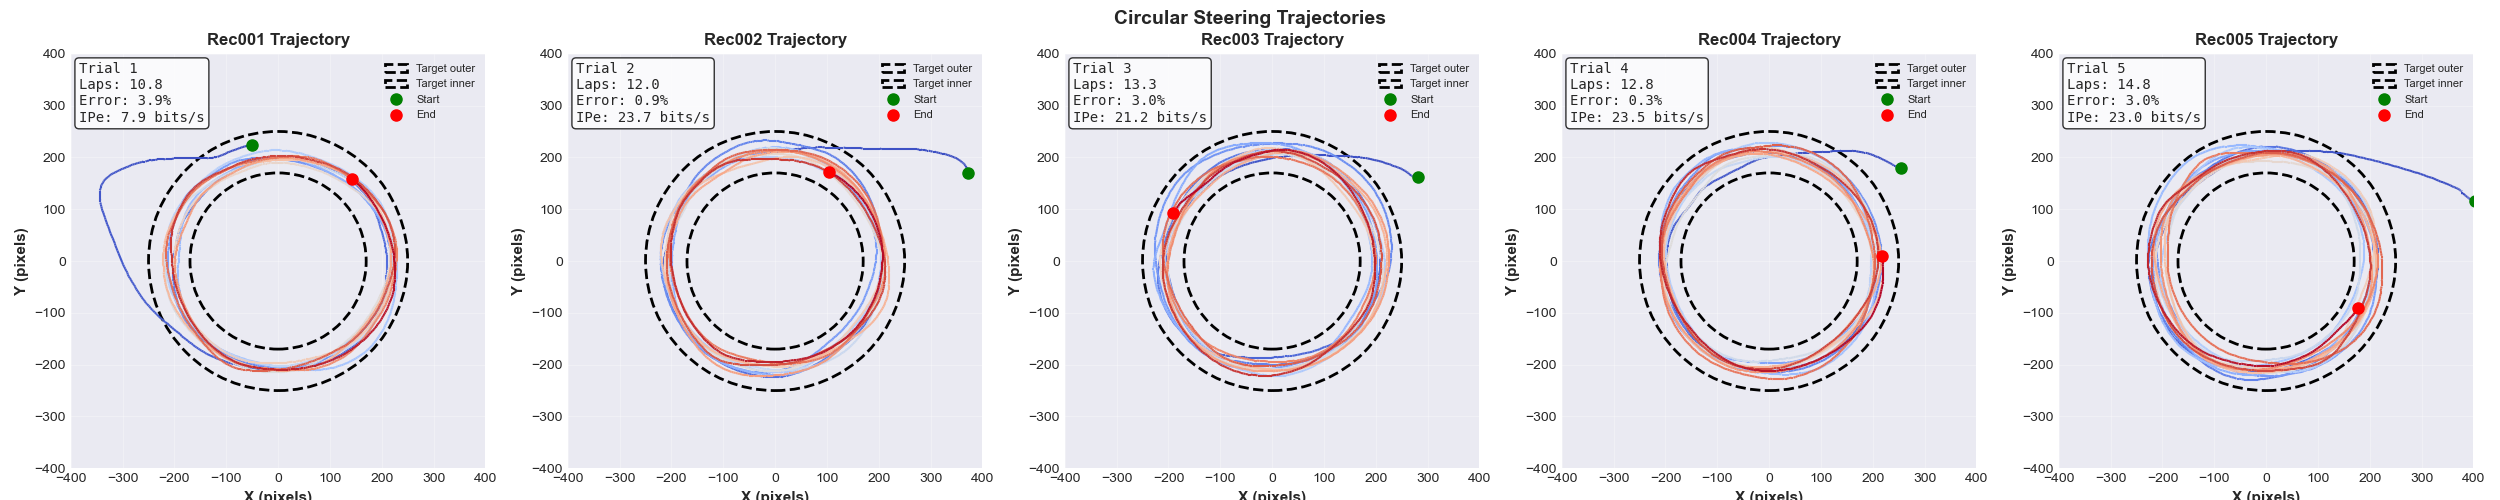

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge
import matplotlib.patches as mpatches
from scipy import stats

# ----------------------
# Visualization (Run after computing results)
# ----------------------

# Set style for better appearance
plt.style.use('seaborn-v0_8-darkgrid')
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']

# ========================
# Figure 1: Trajectory Visualization Variant
# ========================

fig1, axes = plt.subplots(1, len(data_groups), figsize=(5*len(data_groups), 5))
if len(data_groups) == 1:
    axes = [axes]
    
for idx, g in enumerate(data_groups):
    ax = axes[idx]
        
    # Draw target annulus
    circle_outer = Circle((0, 0), EXTERNAL_LIMIT, fill=False, 
                            edgecolor='black', linewidth=2, linestyle='--', label='Target outer')
    circle_inner = Circle((0, 0), INTERNAL_LIMIT, fill=False, 
                            edgecolor='black', linewidth=2, linestyle='--', label='Target inner')
    ax.add_patch(circle_outer)
    ax.add_patch(circle_inner)
        
    # Plot trajectory with color map based on time
    x, y = g['x'], g['y']
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
    from matplotlib.collections import LineCollection
    lc = LineCollection(segments, cmap='coolwarm', linewidth=1.5)
    lc.set_array(np.linspace(0, 1, len(x)))
    ax.add_collection(lc)
        
    # Mark start and end
    ax.plot(x[0], y[0], 'go', markersize=8, label='Start', zorder=5)
    ax.plot(x[-1], y[-1], 'ro', markersize=8, label='End', zorder=5)
        
    # Add metrics text
    if idx < len(results) and results[idx] is not None:
        r = results[idx]
        text = (f"Trial {idx+1}\n"
            f"Laps: {abs(r['nLaps']):.1f}\n"
            f"Error: {r['error']:.1f}%\n"
            f"IPe: {r['IPe']:.1f} bits/s")
        ax.text(0.02, 0.98, text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
    ax.set_xlim(-400, 400)
    ax.set_ylim(-400, 400)
    ax.set_aspect('equal')
    ax.set_xlabel('X (pixels)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Y (pixels)', fontsize=11, fontweight='bold')
    ax.set_title(f'Rec{idx+1:03d} Trajectory', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)
    
plt.suptitle('Circular Steering Trajectories', fontsize=14, fontweight='bold')
plt.tight_layout()
# plt.savefig('figs/trajectories.png', dpi=300, bbox_inches='tight')
plt.show()

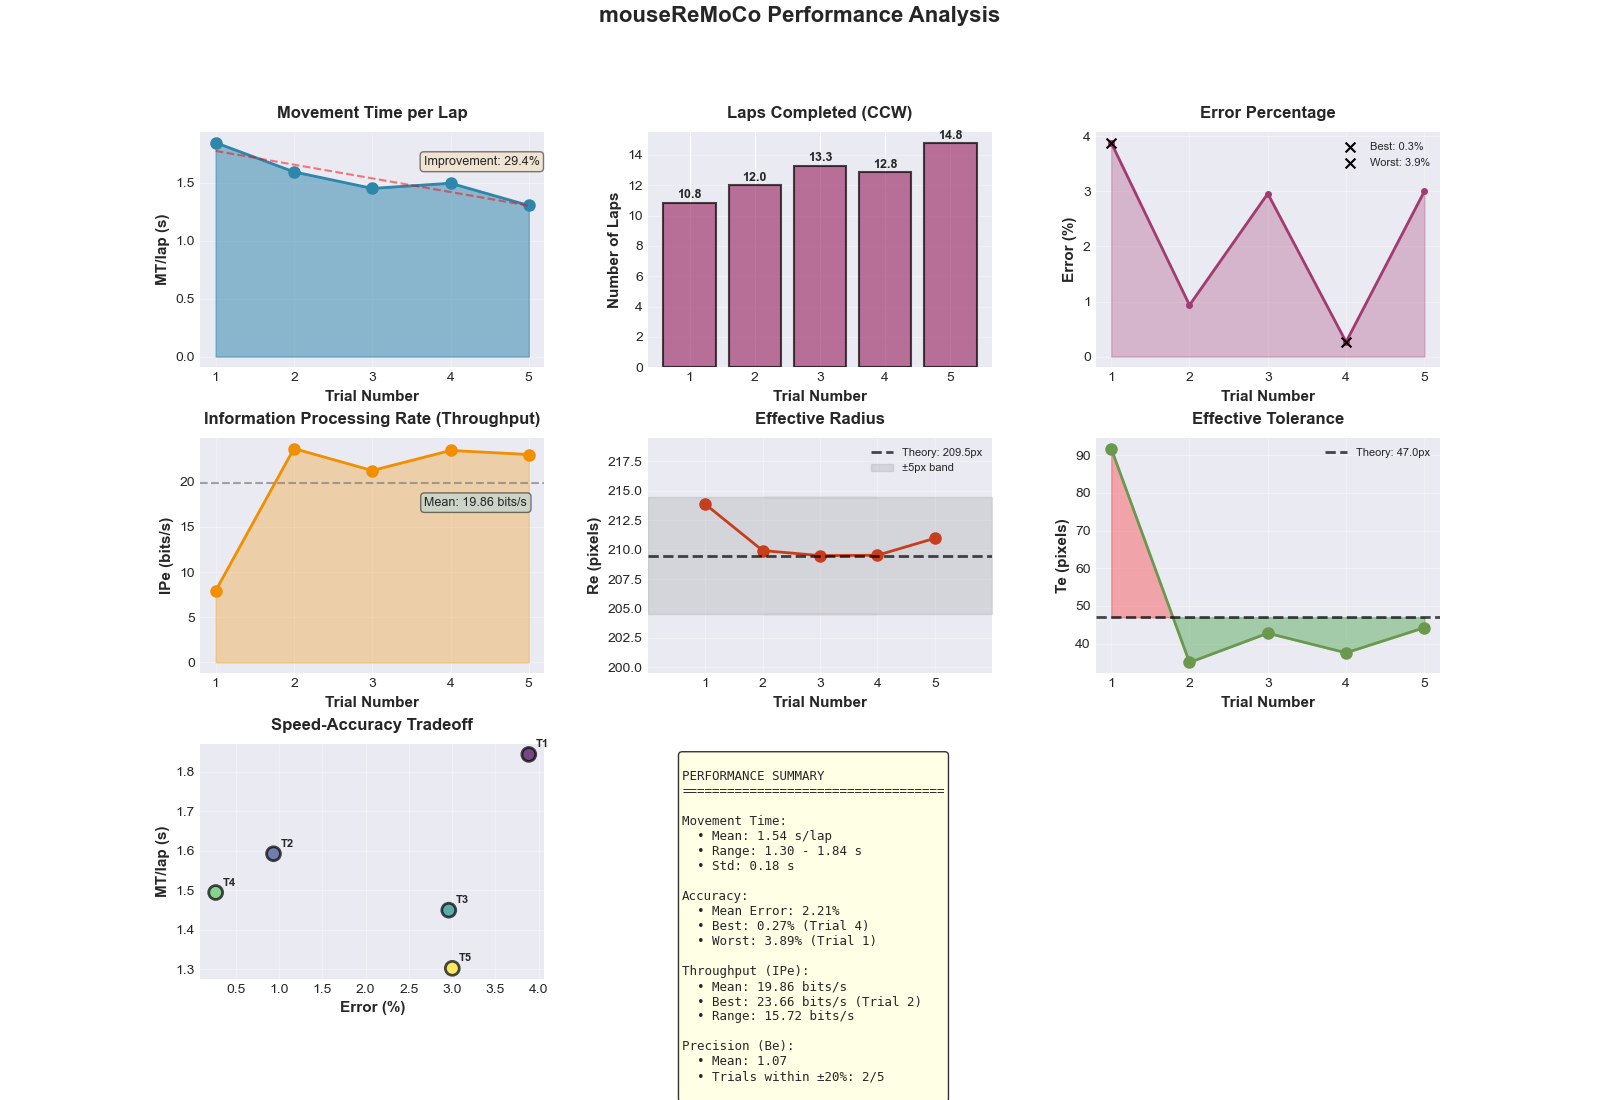

In [71]:
# ========================
# Figure 2: Performance Metrics Over Trials
# ========================
fig2 = plt.figure(figsize=(16, 11))
gs = fig2.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

trial_nums = np.array(range(1, len(results) + 1))

# --- Fig 1 : Movement Time per Lap ---
ax1 = fig2.add_subplot(gs[0, 0])
mt_vals = [r['MT/lap'] for r in results]
ax1.plot(trial_nums, mt_vals, 'o-', color=colors[0], linewidth=2, markersize=8)
ax1.fill_between(trial_nums, mt_vals, alpha=0.3, color=colors[0])
ax1.fill_between(trial_nums, mt_vals, alpha=0.3, color=colors[0])
ax1.set_xlabel('Trial Number', fontsize=11, fontweight='bold')
ax1.set_ylabel('MT/lap (s)', fontsize=11, fontweight='bold')
ax1.set_title('Movement Time per Lap', fontsize=12, fontweight='bold', pad=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(trial_nums)
    
  # Add trend line
if len(trial_nums) > 1:
  z = np.polyfit(trial_nums, mt_vals, 1)
  p = np.poly1d(z)
  ax1.plot(trial_nums, p(trial_nums), '--', alpha=0.5, color='red', linewidth=1.5)
  improvement = ((mt_vals[0] - mt_vals[-1]) / mt_vals[0]) * 100
  ax1.text(0.65, 0.90, f'Improvement: {improvement:.1f}%', 
          transform=ax1.transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
# --- Fig 2 : Number of Laps ---
ax2 = fig2.add_subplot(gs[0, 1])
nlaps_vals = [abs(r['nLaps']) for r in results]
direction = ['CCW' if r['nLaps'] < 0 else 'CW' for r in results]
bars = ax2.bar(trial_nums, nlaps_vals, color=colors[1], alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Trial Number', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Laps', fontsize=11, fontweight='bold')
ax2.set_title(f'Laps Completed ({direction[0]})', fontsize=12, fontweight='bold', pad=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(trial_nums)
    
 # Add lap count on bars
for i, (t, n) in enumerate(zip(trial_nums, nlaps_vals)):
    ax2.text(t, n + 0.3, f'{n:.1f}', ha='center', fontsize=9, fontweight='bold')
    
# --- Fig 3 : Error Percentage ---
ax3 = fig2.add_subplot(gs[0, 2])
error_vals = [r['error'] for r in results]
ax3.plot(trial_nums, error_vals, 'o-', color=colors[1], linewidth=2, markersize=4)
ax3.fill_between(trial_nums, error_vals, alpha=0.3, color=colors[1])
ax3.set_xlabel('Trial Number', fontsize=11, fontweight='bold')
ax3.set_ylabel('Error (%)', fontsize=11, fontweight='bold')
ax3.set_title('Error Percentage', fontsize=12, fontweight='bold', pad=10)
ax3.grid(True, alpha=0.3)
ax3.set_xticks(trial_nums)
    
  # Highlight best and worst
best_idx = np.argmin(error_vals)
worst_idx = np.argmax(error_vals)
ax3.scatter([trial_nums[best_idx]], [error_vals[best_idx]], 
            s=50, color='black', marker='x', zorder=5, label=f'Best: {error_vals[best_idx]:.1f}%')
if best_idx != worst_idx:
    ax3.scatter([trial_nums[worst_idx]], [error_vals[worst_idx]], 
              s=50, color='black', marker='x', zorder=5, label=f'Worst: {error_vals[worst_idx]:.1f}%')
ax3.legend(loc='upper right', fontsize=8)
    
# --- Fig 4 : Information Processing Rate (IPe) ---
ax4 = fig2.add_subplot(gs[1, 0])
ipe_vals = [r['IPe'] for r in results]
ax4.plot(trial_nums, ipe_vals, 'o-', color=colors[2], linewidth=2, markersize=8)
ax4.fill_between(trial_nums, ipe_vals, alpha=0.3, color=colors[2])
ax4.set_xlabel('Trial Number', fontsize=11, fontweight='bold')
ax4.set_ylabel('IPe (bits/s)', fontsize=11, fontweight='bold')
ax4.set_title('Information Processing Rate (Throughput)', fontsize=12, fontweight='bold', pad=10)
ax4.grid(True, alpha=0.3)
ax4.set_xticks(trial_nums)
    
  # Add mean line
mean_ipe = np.mean(ipe_vals)
ax4.axhline(y=mean_ipe, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax4.text(0.95, 0.75, f'Mean: {mean_ipe:.2f} bits/s', 
        transform=ax4.transAxes, fontsize=9, verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
# --- Fig 5 : Effective Radius (Re) ---
ax5 = fig2.add_subplot(gs[1, 1])
re_vals = [r['Re'] for r in results]
ax5.plot(trial_nums, re_vals, 'o-', color=colors[3], linewidth=2, markersize=8)
ax5.axhline(y=R_theory, color='black', linestyle='--', linewidth=2, alpha=0.7, label=f'Theory: {R_theory:.1f}px')
expanded_x = np.concatenate([trial_nums - 1, trial_nums + 1])
ax5.fill_between(expanded_x, y1=R_theory - 5, y2=R_theory + 5, alpha=0.2, color='gray', label='±5px band')
ax5.set_xlim(trial_nums.min() - 1, trial_nums.max() + 1)
ax5.set_ylim(R_theory - 10, R_theory + 10)
ax5.set_xlabel('Trial Number', fontsize=11, fontweight='bold')
ax5.set_ylabel('Re (pixels)', fontsize=11, fontweight='bold')
ax5.set_title('Effective Radius', fontsize=12, fontweight='bold', pad=10)
ax5.grid(True, alpha=0.3)
ax5.set_xticks(trial_nums)
ax5.legend(loc='best', fontsize=8)
    
# --- Fig 6 : Effective Tolerance (Te) ---
ax6 = fig2.add_subplot(gs[1, 2])
te_vals = [r['Te'] for r in results]
ax6.plot(trial_nums, te_vals, 'o-', color=colors[4], linewidth=2, markersize=8)
ax6.axhline(y=T_theory, color='black', linestyle='--', linewidth=2, alpha=0.7, label=f'Theory: {T_theory:.1f}px')
ax6.fill_between(trial_nums, te_vals, T_theory, alpha=0.3, 
                where=np.array(te_vals) >= T_theory, color='red', interpolate=True)
ax6.fill_between(trial_nums, te_vals, T_theory, alpha=0.3, 
                where=np.array(te_vals) < T_theory, color='green', interpolate=True)
ax6.set_xlabel('Trial Number', fontsize=11, fontweight='bold')
ax6.set_ylabel('Te (pixels)', fontsize=11, fontweight='bold')
ax6.set_title('Effective Tolerance', fontsize=12, fontweight='bold', pad=10)
ax6.grid(True, alpha=0.3)
ax6.set_xticks(trial_nums)
ax6.legend(loc='best', fontsize=8)
    
# --- Fig 7 : Speed-Accuracy Tradeoff ---
ax7 = fig2.add_subplot(gs[2, 0])
scatter = ax7.scatter(error_vals, mt_vals, c=trial_nums, cmap='viridis', 
                      s=100, alpha=0.7, edgecolors='black', linewidth=2)
ax7.set_xlabel('Error (%)', fontsize=11, fontweight='bold')
ax7.set_ylabel('MT/lap (s)', fontsize=11, fontweight='bold')
ax7.set_title('Speed-Accuracy Tradeoff', fontsize=12, fontweight='bold', pad=10)
ax7.grid(True, alpha=0.3)
    
  # Add trial labels
for i, (e, m) in enumerate(zip(error_vals, mt_vals)):
    ax7.annotate(f'T{i+1}', (e, m), xytext=(5, 5), textcoords='offset points', 
                fontsize=8, fontweight='bold')
    
# cbar = plt.colorbar(scatter, ax=ax7)
# cbar.set_label('Trial Number', fontsize=10)
    
# --- Summary Statistics ---
ax8 = fig2.add_subplot(gs[2, 1])
ax8.axis('off')
    
summary_text = f"""
PERFORMANCE SUMMARY
{'='*35}
    
Movement Time:
  • Mean: {np.mean(mt_vals):.2f} s/lap
  • Range: {np.min(mt_vals):.2f} - {np.max(mt_vals):.2f} s
  • Std: {np.std(mt_vals):.2f} s
    
Accuracy:
  • Mean Error: {np.mean(error_vals):.2f}%
  • Best: {np.min(error_vals):.2f}% (Trial {np.argmin(error_vals)+1})
  • Worst: {np.max(error_vals):.2f}% (Trial {np.argmax(error_vals)+1})
    
Throughput (IPe):
  • Mean: {np.mean(ipe_vals):.2f} bits/s
  • Best: {np.max(ipe_vals):.2f} bits/s (Trial {np.argmax(ipe_vals)+1})
  • Range: {np.max(ipe_vals) - np.min(ipe_vals):.2f} bits/s
    
Precision (Be):
  • Mean: {np.mean(be_vals):.2f}
  • Trials within ±20%: {sum(0.8 <= b <= 1.2 for b in be_vals)}/{len(be_vals)}
"""
    
ax8.text(0.1, 0.95, summary_text, transform=ax8.transAxes, fontsize=9,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
plt.suptitle('mouseReMoCo Performance Analysis', fontsize=16, fontweight='bold', y=0.995)
# plt.savefig('figs/performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

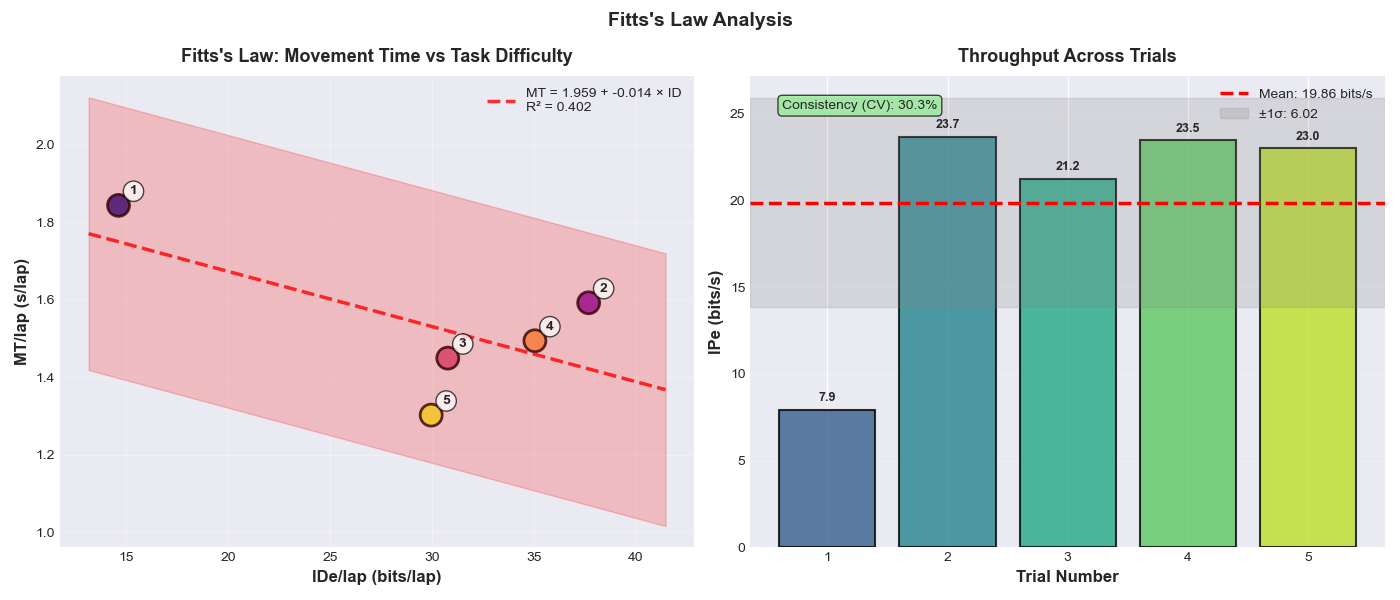

In [ ]:
# ========================
# Figure 3: Fitts's Law Analysis
# ========================
fig3, axes = plt.subplots(1, 2, figsize=(14, 6))

ide_vals = [r['IDe/lap'] for r in results]
mt_vals = [r['MT/lap'] for r in results]
# --- Classic Fitts's Law Plot ---
ax = axes[0]
scatter = ax.scatter(ide_vals, mt_vals, c=trial_nums, cmap='plasma', 
                    s=250, alpha=0.8, edgecolors='black', linewidth=2)

# Linear regression
if len(ide_vals) > 1:
    slope, intercept, r_value, p_value, std_err = stats.linregress(ide_vals, mt_vals)
    x_fit = np.linspace(min(ide_vals)*0.9, max(ide_vals)*1.1, 100)
    y_fit = slope * x_fit + intercept
    ax.plot(x_fit, y_fit, 'r--', linewidth=2.5, alpha=0.8,
        label=f'MT = {intercept:.3f} + {slope:.3f} × ID\nR² = {r_value**2:.3f}')
    
# 95% confidence interval
predict_std = np.sqrt(np.sum((mt_vals - (slope * np.array(ide_vals) + intercept))**2) / (len(mt_vals) - 2))
margin = 1.96 * predict_std
ax.fill_between(x_fit, y_fit - margin, y_fit + margin, alpha=0.2, color='red')

# Add trial labels
for i, (ide, mt) in enumerate(zip(ide_vals, mt_vals)):
    ax.annotate(f'{i+1}', (ide, mt), xytext=(8, 8), textcoords='offset points',
               fontsize=10, fontweight='bold', 
               bbox=dict(boxstyle='circle', facecolor='white', alpha=0.7))

ax.set_xlabel('IDe/lap (bits/lap)', fontsize=12, fontweight='bold')
ax.set_ylabel('MT/lap (s/lap)', fontsize=12, fontweight='bold')
ax.set_title("Fitts's Law: Movement Time vs Task Difficulty", fontsize=13, fontweight='bold', pad=10)
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)
#cbar = plt.colorbar(scatter, ax=ax)
#cbar.set_label('Trial Number', fontsize=10)
    
# --- Throughput Consistency ---
ax2 = axes[1]
ipe_vals = [r['IPe'] for r in results]
    
# Bar plot with color gradient
colors_grad = plt.cm.viridis(np.linspace(0.3, 0.9, len(trial_nums)))
bars = ax2.bar(trial_nums, ipe_vals, color=colors_grad, alpha=0.8, 
                edgecolor='black', linewidth=1.5)
    
# Add mean line
mean_ipe = np.mean(ipe_vals)
ax2.axhline(y=mean_ipe, color='red', linestyle='--', linewidth=2.5, 
            label=f'Mean: {mean_ipe:.2f} bits/s')
    
# Add ±1 std band
std_ipe = np.std(ipe_vals)
ax2.axhspan(mean_ipe - std_ipe, mean_ipe + std_ipe, alpha=0.2, color='gray',
            label=f'±1σ: {std_ipe:.2f}')
    
# Add values on top of bars
for i, (t, ipe) in enumerate(zip(trial_nums, ipe_vals)):
    ax2.text(t, ipe + 0.5, f'{ipe:.1f}', ha='center', fontsize=9, fontweight='bold')
    
ax2.set_xlabel('Trial Number', fontsize=12, fontweight='bold')
ax2.set_ylabel('IPe (bits/s)', fontsize=12, fontweight='bold')
ax2.set_title('Throughput Across Trials', fontsize=13, fontweight='bold', pad=10)
ax2.legend(loc='best', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(trial_nums)
    
# Calculate coefficient of variation
cv = (std_ipe / mean_ipe) * 100
ax2.text(0.05, 0.95, f'Consistency (CV): {cv:.1f}%', 
        transform=ax2.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    
plt.suptitle("Fitts's Law Analysis", fontsize=14, fontweight='bold')
plt.tight_layout()
# plt.savefig('figs/fitts_law_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# https://nbconvert.readthedocs.io/en/latest/removing_cells.html

# https://github.com/msm1089/ipynbname/issues/17#issuecomment-1293269863


from traitlets.config import Config
from nbconvert.exporters import HTMLExporter
from nbconvert.preprocessors import TagRemovePreprocessor
from IPython import get_ipython


def get_notebook_name():
    """
    Get the current notebook name (without extension).
    """
    ip = get_ipython()
    path = None
    if "__vsc_ipynb_file__" in ip.user_ns:
        path = ip.user_ns["__vsc_ipynb_file__"]

    return path.split("/")[-1].split(".")[0]


# Get the notebook name
notebook_file_name = get_notebook_name()


# Setup config
c = Config()

# Configure tag removal - be sure to tag your cells to remove  using the
# words remove_cell to remove cells. You can also modify the code to use
# a different tag word
c.TagRemovePreprocessor.remove_cell_tags = ("remove",)
c.TagRemovePreprocessor.remove_all_outputs_tags = ("remove_output",)
c.TagRemovePreprocessor.remove_input_tags = ("hide",)
c.TagRemovePreprocessor.enabled = True
c.HTMLExporter.preprocessors = ["nbconvert.preprocessors.TagRemovePreprocessor"]

# ensure the graphics are included in the html
c.HTMLExporter.embed_images = True
# do not show the input code cells (distracts from the output)
c.HTMLExporter.exclude_output_prompt = True
c.HTMLExporter.exclude_input_prompt = True

# Configure the exporter
exporter = HTMLExporter(config=c)
exporter.register_preprocessor(TagRemovePreprocessor(config=c), True)


# run our exporter - returns a tuple - first element with html,
# second with notebook metadata
output = HTMLExporter(config=c).from_filename(notebook_file_name + ".ipynb")

# Write to output html file
with open(notebook_file_name + ".html", "w") as f:
    f.write(output[0])

# open the file with the operating system
import os

# if osx use open, if linux use xdg-open, if windows use start
try:
    if os.name == "posix":
        if os.uname().sysname == "Darwin":
            # macOS
            errorCode = os.system("open " + notebook_file_name + ".html")
        else:
            # Linux
            errorCode = os.system("xdg-open " + notebook_file_name + ".html")
    elif os.name == "nt":
        # Windows
        errorCode = os.system("start " + notebook_file_name + ".html")
    else:
        print("Unsupported OS")
except Exception as e:
    print("Error opening file: ", e)